<a ><img src="Pictures/trashpanda.png"  width="70" align="left"> </a>
<div style="text-align: right"> <h3><span style="color:gray"> DRAFT </span> </h3> </div>

<br>
<br>
<br>

<a ><img src="Pictures/Icon.png" Width="250" align="center"> </a>

<br>
<br>



<h1><center>Sentiment Analysis</center></h1>
<h2><center> <span style="font-weight:normal"><font color='#022F73'> 
Natural Language Processing (NLP): <br> Analysis of Headlines with VADER and pysentiment </font>  </span></center></h2>


<h3><center><font color='gray'>JONAS GOTTAL</font></center></h3>

#### About this Notebook
We will conduct a sentiment Analysis with ```VADER``` *(Valence Aware Dictionary for Sentiment Reasoning)*  <br> 
and ```pysentiment```, a pre-trained finance-focused Model, on headlines of several different news outlets with <br> 
impact on german financial markets and generate for each a dedicated sentiment KPI per trading day. <br> 
In the end we will have a sound time series  and - hopefully - some predictive results.<br> 
*The approach is a more explorative data analysis, therefore some parts will be redundant in the end.*
<br>
<br>


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="text-decoration:none; margin-top: 30px; background-color:#F2F2F2; border-color:#022F73">
    <span style="color:#022F73">
    <ol>
      <li><a href="#1"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Motivation  </span> </a></li>
      <li><a href="#2"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Approach  </span> </a></li>
      <li><a href="#3"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Data Analysis</span> </a></li>
        <ol>
         <li><a href="#4"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
           >Import of our Sentiment Data</span> </a></li>   
         <li><a href="#5"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
           >Include Market Data</span> </a></li>
         <li><a href="#6"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
           >Merge both Time Series</span> </a></li>
         <li><a href="#7"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
           >Exploratory analysis: Correlation and Significance</span> </a></li>
           <li><a href="#8"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
           >Robust analysis: Simple linear Regression</span> </a></li>
        </ol>
      <li><a href="#9"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Critique</span> </a></li>
    </ol>
    </span>
</div>

In [1]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML, display
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import dtale
pd.set_option('display.max_rows', None)

# 1. Motivation <a id="1"></a>


> <i> "There are three ways to make a living in this business: be first, be smarter, or cheat. Well, I don't cheat. And although I like to think we have some pretty smart people here in this room, it sure is a hell of lot easier to just be first." </i> **- Margin Call** 

But to be the first to use market data, you would need to be in an optimal physical location (depending on the stock exchanges) and you have to have the fastest connection. Neither of those is true for me and many others. So to be successful - in this analogy of margin call - you would have to design/manipulate a unique set of data - and therefore be first again.

## Why headlines of causal News Outlets?

The market participants have drastically changed in the last years: The most influencing Trades are from the retail traders! 
(under the assumption that HF Traders don't change prices significantly and only profit from small fractions and arbitrage opportunities)

<a ><img src="Pictures/Retail1.png"  width="600" align="left"> </a>



<a ><img src="Pictures/Retail2.png"  width="350" align="right"> </a>


And therefore we focus on the source of information of those retail traders: news outlets

And because most only skim the contents and mostly only read the headline, we will focus on their sentiment.


Why not use NLP on specific stocks (e.g. only news articles on AAPL )?
My assumption is, that no (retail) investor will make a decision on one single (normal) news headline.
But the entirety of the current market sentiment, might be a predictor of market activity and volatility and hence daily risk appetite. Therefore we are going to analyse the total addressable market of media outlets. 

(Also there are already too many (large) market participants who analyse the sentiment by single stocks for news articles and social media/forum posts {e.g. r/wsb}— so not an opportunity for strat arb!)

# 2. Approach <a id="2"></a>

> <i>"Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data." </i> - Wikipedia

Sentiment analysis is a text analysis method that detects polarity (e.g. a positive or negative opinion) within the text, whether a whole document, paragraph, sentence, or clause.

Sentiment analysis aims to measure the attitude, sentiments, evaluations, attitudes, and emotions of a speaker/writer based on the computational treatment of subjectivity in a text.

This is a library for sentiment analysis in dictionary framework. Two dictionaries are provided in the library, namely, *[Harvard IV-4](http://www.wjh.harvard.edu/~inquirer/homecat.htm)* and *[Loughran and McDonald Financial Sentiment Dictionaries](https://sraf.nd.edu/)*, which are sentiment dictionaries for general and financial sentiment analysis.

##### Introduction

```Positive``` and ```Negative``` are word counts for the words in positive and negative sets.

```Polarity``` and ```Subjectivity``` are calculated in the same way of [Lydia](http://www.cs.sunysb.edu/~skiena/lydia/) system.

The formula for Polarity is:

$$
Polarity = \frac{Pos - Neg}{Pos + Neg}
$$

The formula for Subjectivity is:

$$
Subjectivity = \frac{Pos + Neg}{count}
$$


# 3. Analysis of our unique dataset <a id="3"></a>

We will approach our analysis as followed:

A. Import and plot of sentiment data

B. Download of market data and calculation of relevant metrics

C. Merge of both time series

D. Exploratory analysis: Search for Correlation and Significance

E. Explanatory analysis: Plot regression and evaluate model

## A. Import of our Sentiment Data <a id="4"></a>

##### Our main goal is to compares our different scores of our timeseries against (german) financial markets

We will compare:
- ```VADER``` Score
- Polarity and Subjectivity ```Pysentiment HIV-4``` Scores 
- Polarity and Subjectivity ```Pysentiment LM``` Scores 


Let's read our data from the csv File!

In [2]:
df = pd.read_csv('daily_scores.csv', sep = ',') 

In [3]:
df = df.drop(columns=['Unnamed: 0'])
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # convert column to datetime object
df.set_index('Timestamp', inplace=True)  # set column 'date' to index
df.index.names = ['Date']
df = df.dropna()

And now we have a first glance with ```dtale```

In [4]:
#dtale.show(df, ignore_duplicate=True)

Let's plot our scores to get a better visual:

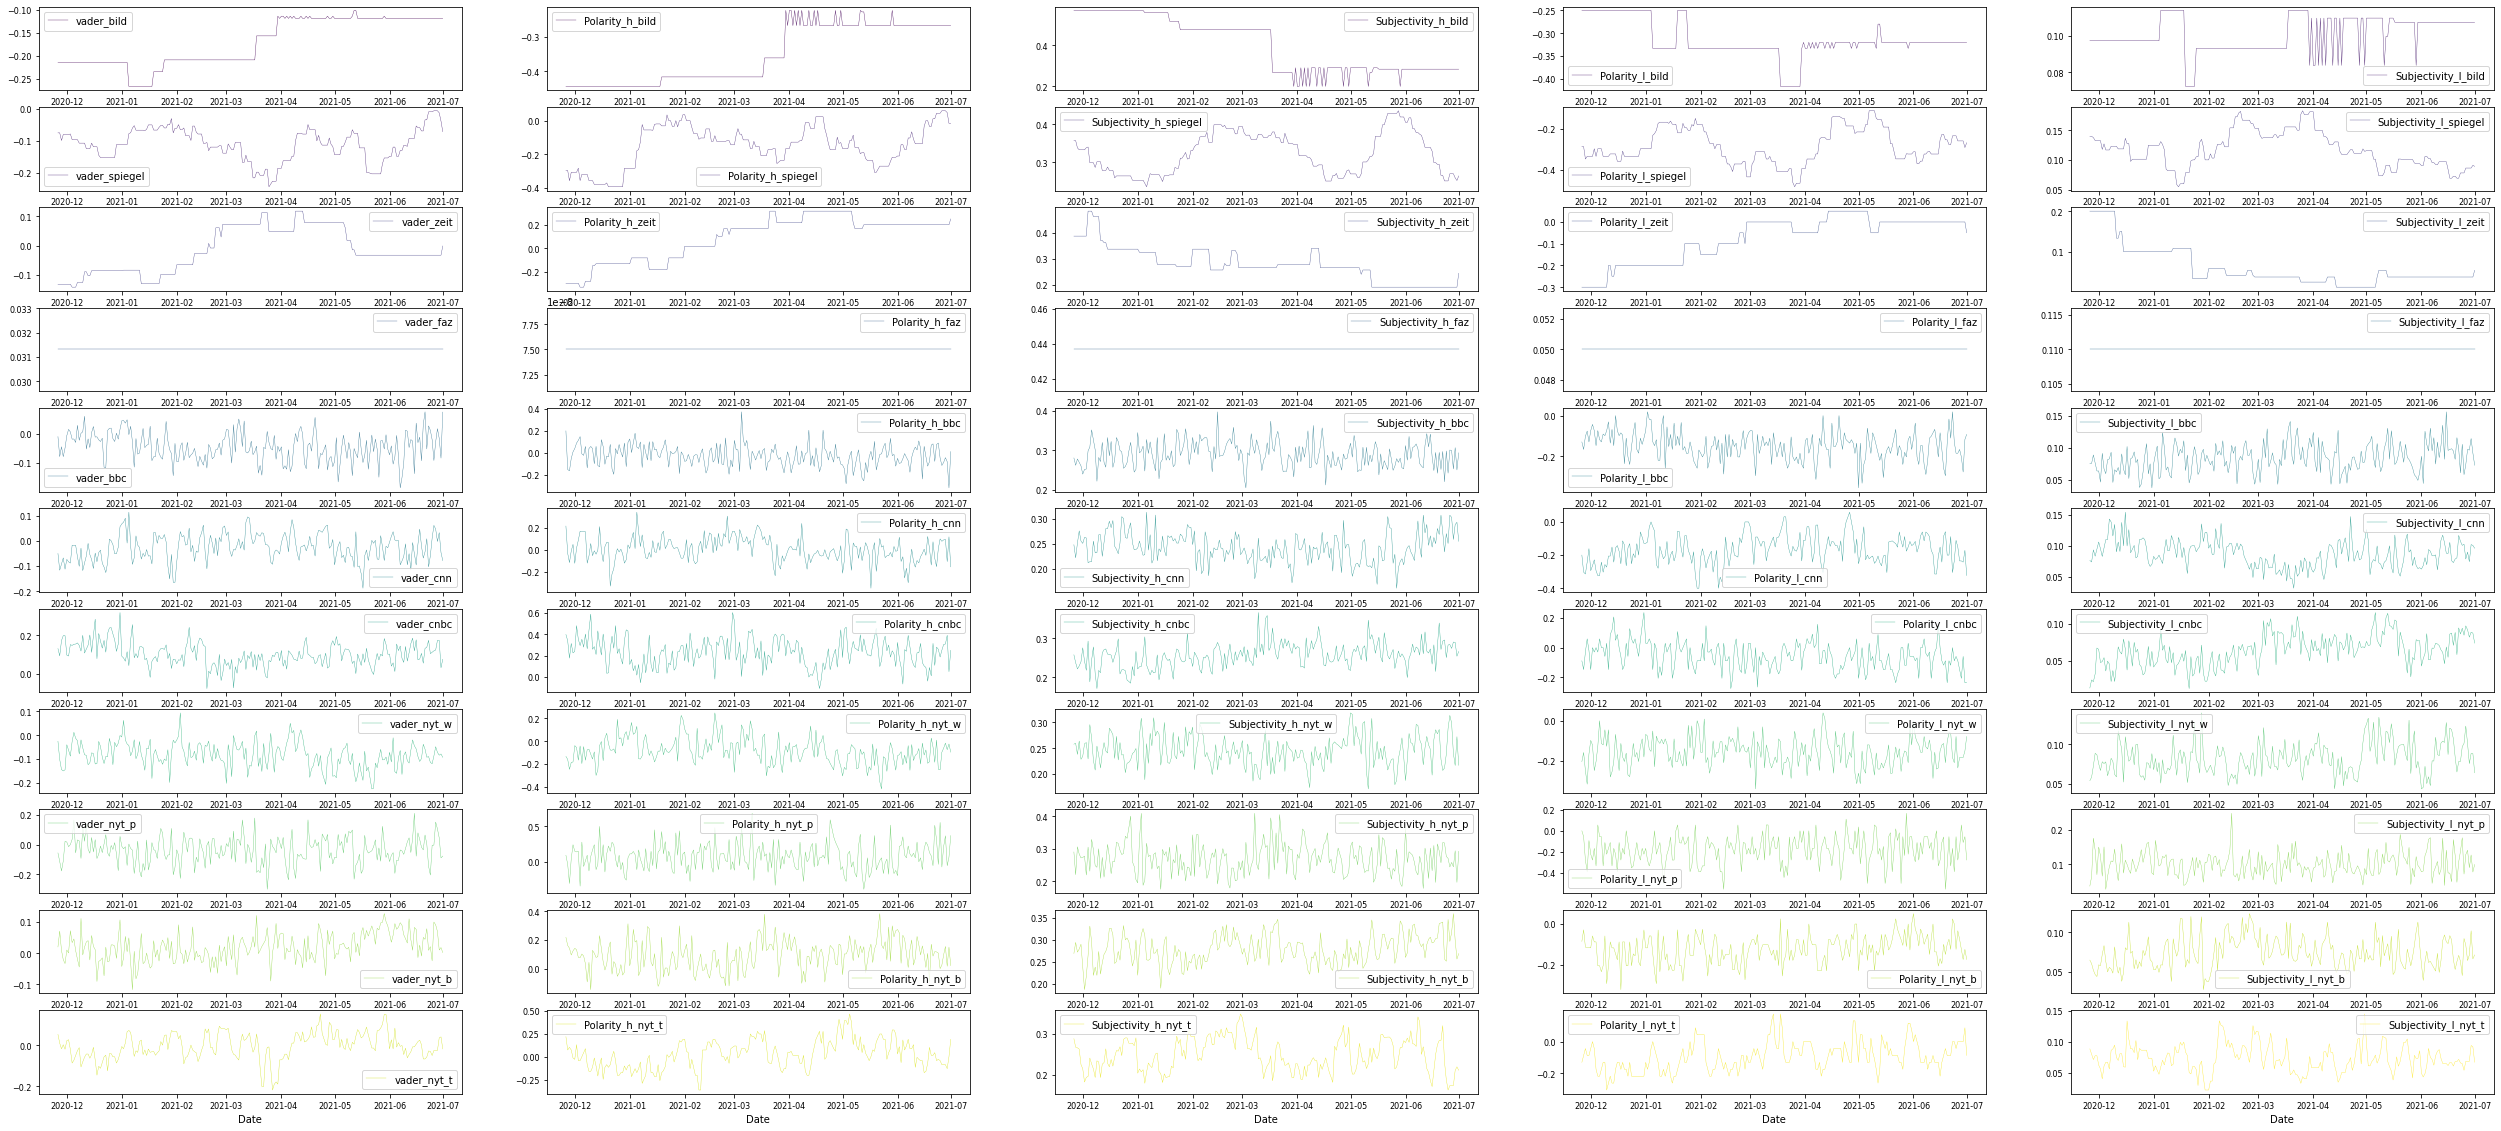

In [5]:
df.plot(subplots=True,
        figsize=(44,20),
          layout=(11, 5),
          sharex=False,
          sharey=False,
          colormap='viridis',
         fontsize=8,
         #legend=False,
         linewidth=0.35)
#plt.show()
plt.savefig('Sentiment Data.pdf')

We can see FAZ didn't work out as planned -- obviously the website changed and I didn't realize it. Also Bild, Spiegel and Zeit don't have a lot of changes -- The reason: Those are the english Versions of german websites and most likely don't get the same amount of content.

## B. Include Market Data <a id="5"></a>

Let's get some market Data! For germany the DAX, SPY, TECDAX, STOXX50, MDAX and SDAX are the most correlated indexes -- especially for retail traders.

In [6]:
DAX = yf.download("DAX", start="2020-11-20", end="2021-07-07") 
SPY = yf.download("SPY", start="2020-11-20", end="2021-07-07") 
TECDAX = yf.download("^TECDAX", start="2020-11-20", end="2021-07-07") 
STOXX50E = yf.download("^STOXX50E", start="2020-11-20", end="2021-07-07") 
MDAXI = yf.download("^MDAXI", start="2020-11-20", end="2021-07-07") 
SDAXI = yf.download("^SDAXI", start="2020-11-20", end="2021-07-07") 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Let's have a look at the market data with ```dtale```

In [8]:
data = DAX
#dtale.show(data, ignore_duplicate=True)

Now we calculate the daily returns, daily changes and log returns. We also calculate our daily STD and the volatility.

In [9]:
# calculate daily logarithmic return
data['Daily returns'] = data['Adj Close']/data['Adj Close'].shift()
data['Daily volume'] = data['Volume']/data['Volume'].shift()

data['Daily change'] = data['Adj Close'].pct_change()**2
data[['Daily change']] = StandardScaler().fit_transform(data[['Daily change']])

data['Log returns'] = np.log(data['Adj Close']/data['Adj Close'].shift())


# calculate daily standard deviation of returns
daily_std = data['Log returns'].std()

# annualized daily standard deviation

volatility = daily_std*252**.5


It's always important to check the distribution!

Text(0.5, 1.0, 'DAX volatility: 15.98%')

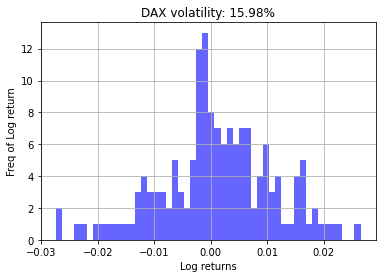

In [10]:
str_vol = str(round(volatility, 4)*100)
fig, ax = plt.subplots()
data['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel('Log returns')
ax.set_ylabel('Freq of Log return')
ax.set_title('DAX volatility: ' + str_vol + '%')

<AxesSubplot:xlabel='Date'>

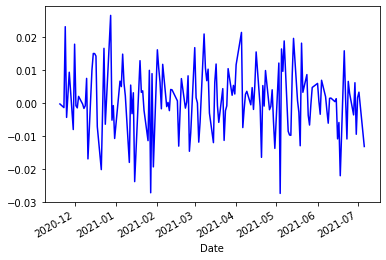

In [11]:
data['Log returns'].plot(color='b')

For our volatility metric we use [realized volatility](https://en.wikipedia.org/wiki/Realized_variance) which is the square root of realized variance. The key differences from the standard deviation of returns are:

- We use Log returns
- It's annualized
- In the case Variance Swaps, log returns are not demeaned

In [12]:
window = 5  # trading days in rolling window
days_per_year = 252  # trading days per year
ann_factor = days_per_year / window

# Var Swap (returns are not demeaned)
data['real_var'] = np.square(data['Log returns']).rolling(window).sum() * ann_factor
data['real_vol'] = np.sqrt(data['real_var'])

# Classical (returns are demeaned, dof=1)
data['classical_var'] = data['Log returns'].rolling(window).var() * ann_factor
data['classical_vol'] = np.sqrt(data['classical_var'])

We use a rolling window of 5 Trading Days, because thats roundabout the time news will be on the website.

Next we plot our variance and volatility

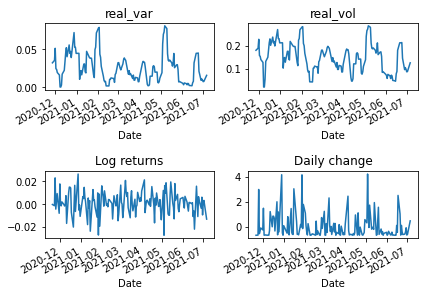

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2)

fig.tight_layout()
data['real_var'].plot(ax=axes[0,0]); axes[0,0].set_title('real_var')

data['real_vol'].plot(ax=axes[0,1]); axes[0,1].set_title('real_vol')

data['Log returns'].plot(ax=axes[1,0]); axes[1,0].set_title('Log returns')

data['Daily change'].plot(ax=axes[1,1]); axes[1,1].set_title('Daily change')
plt.subplots_adjust(wspace=0.2, hspace=1.2)

plt.show()

Now for all Time Series:

In [14]:
def adjust_returns(data):
    data['Daily returns'] = data['Adj Close']/data['Adj Close'].shift()
    data['Daily volume'] = data['Volume']/data['Volume'].shift()
    data['Daily change'] = data['Adj Close'].pct_change()**2
    data[['Daily change']] = StandardScaler().fit_transform(data[['Daily change']])
    data['Log returns'] = np.log(data['Adj Close']/data['Adj Close'].shift())
    daily_std = data['Log returns'].std()
    volatility = daily_std*252**.5
    window = 5  
    days_per_year = 252  
    ann_factor = days_per_year / window
    data['real_var'] = np.square(data['Log returns']).rolling(window).sum() * ann_factor
    data['real_vol'] = np.sqrt(data['real_var'])
    data['classical_var'] = data['Log returns'].rolling(window).var() * ann_factor
    data['classical_vol'] = np.sqrt(data['classical_var'])

In [15]:
market_data = ["DAX", "SPY", "TECDAX", "STOXX50E", "MDAXI", "SDAXI"]

In [16]:
for m in market_data:
    exec(f'adjust_returns({m})') 

In [17]:
# Unfortunately inaccurate volume data due to free provider (Yahoo Parser)
TECDAX = TECDAX.drop(columns=['Volume', 'Daily volume'])
SDAXI = SDAXI.drop(columns=['Volume', 'Daily volume'])

## C. Merge Time Series <a id="6"></a>

Now the most interesting part: combining the market data with our sentiment analysis!

In [18]:
data = pd.merge(df,data, how='inner', left_index=True, right_index=True)

Let's merge all:

In [19]:
for m in market_data:
    exec(f'{m} = pd.merge(df,{m}, how="inner", left_index=True, right_index=True)') 
    exec(f'{m} = {m}.dropna()') 

Let's have a look at the correlations with ```dtale```

In [20]:
#dtale.show(data, ignore_duplicate=True)

## D. Exploratory analysis: Correlation and Significance <a id="7"></a>

<b>P-value</b>: 
<p>What is this P-value? The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.</p>

By convention, when the
<ul>
    <li>p-value is $<$ 0.001: we say there is strong evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.05: there is moderate evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.1: there is weak evidence that the correlation is significant.</li>
    <li>the p-value is $>$ 0.1: there is no evidence that the correlation is significant.</li>
</ul>

In [21]:
# We define our correlation matrix....

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# ...and then make our plot including mask to blank out what we don't need
def plot_cor_matrix(corr, mask=None):
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(30, 30))
        sns.heatmap(corr, ax=ax,
                    mask=mask,
                    # cosmetics
                    annot=True, vmin=-1, vmax=1, center=0,
                    cmap='coolwarm', cbar = False)

In [22]:
# Plotting with significance filter
def make_plot(data):
    p_values = corr_sig(data)                   # get p-Value
    plot_cor_matrix(data.corr(), np.invert(np.tril(p_values<0.01)))  # Plot for correlation and mask for p-values


In [23]:
# Drop the first 61 Rows with Sentiment Data -> Correlation between these is irrelevant
# Plotting with significance filter
def make_small_plot(data):
    p_values = corr_sig(data)                   # get p-Value
    plot_small_cor_matrix(data.corr().iloc[61: , :], np.invert(np.tril(p_values<0.01))[61:, :])  # Plot for correlation and mask for p-values


In [24]:
def plot_small_cor_matrix(corr, mask=None):
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(30,5.75))
        sns.heatmap(corr, ax=ax,
                    mask=mask,
                    # cosmetics
                    annot=True, vmin=-1, vmax=1, center=0,
                    cmap='coolwarm', cbar = False)

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; 

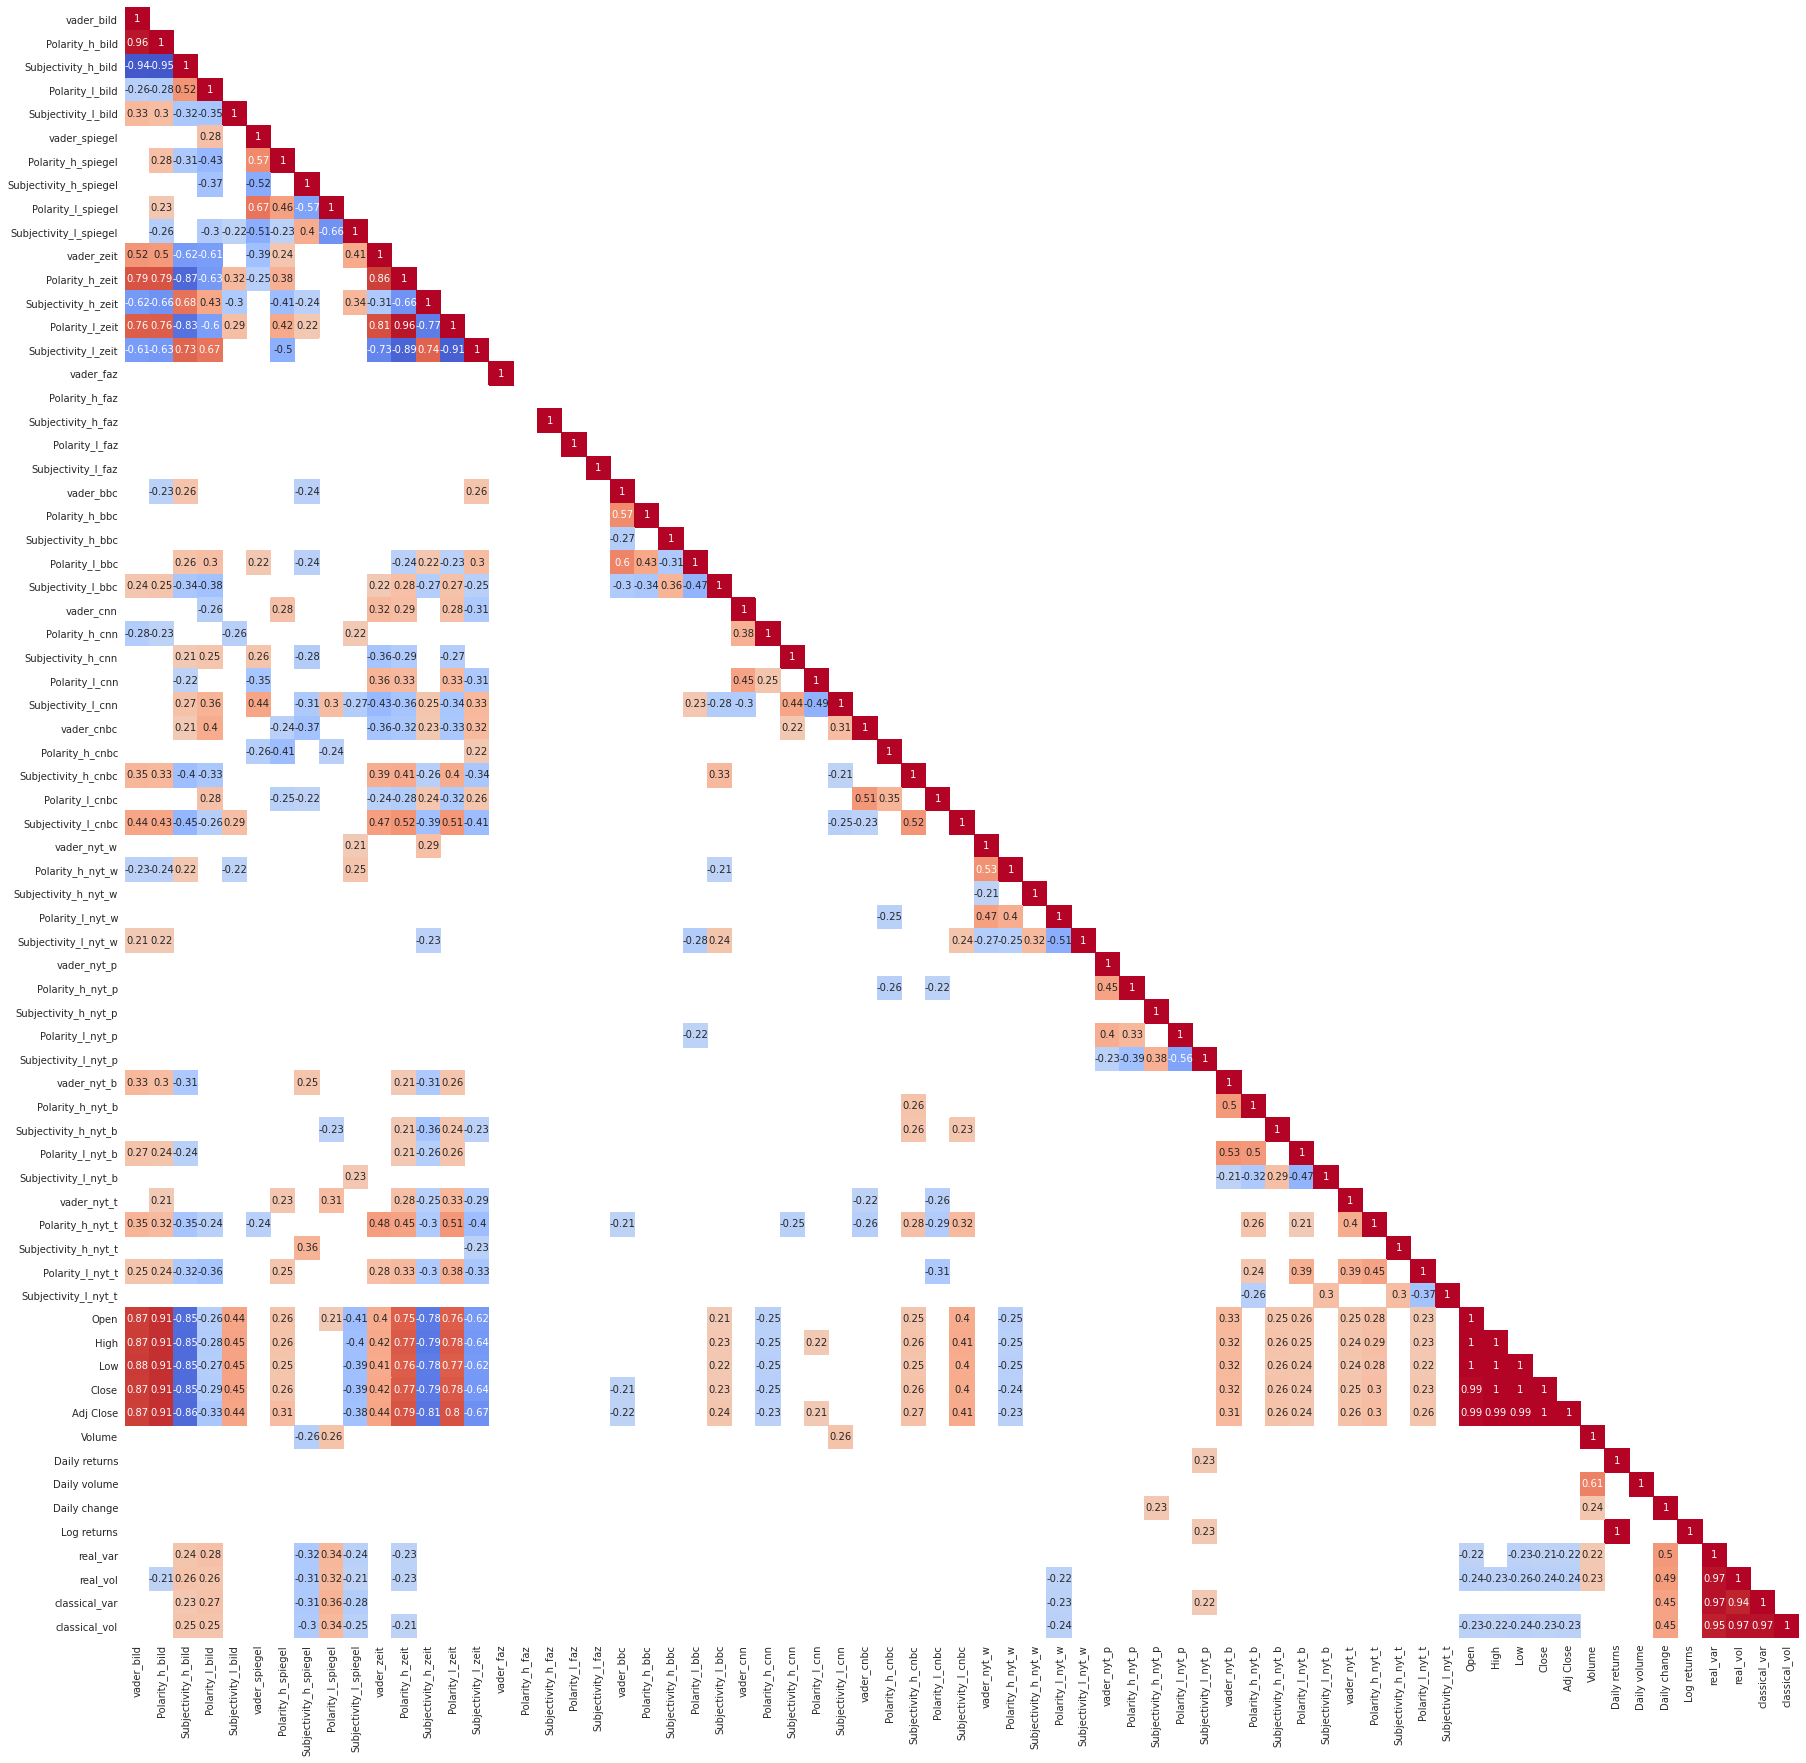

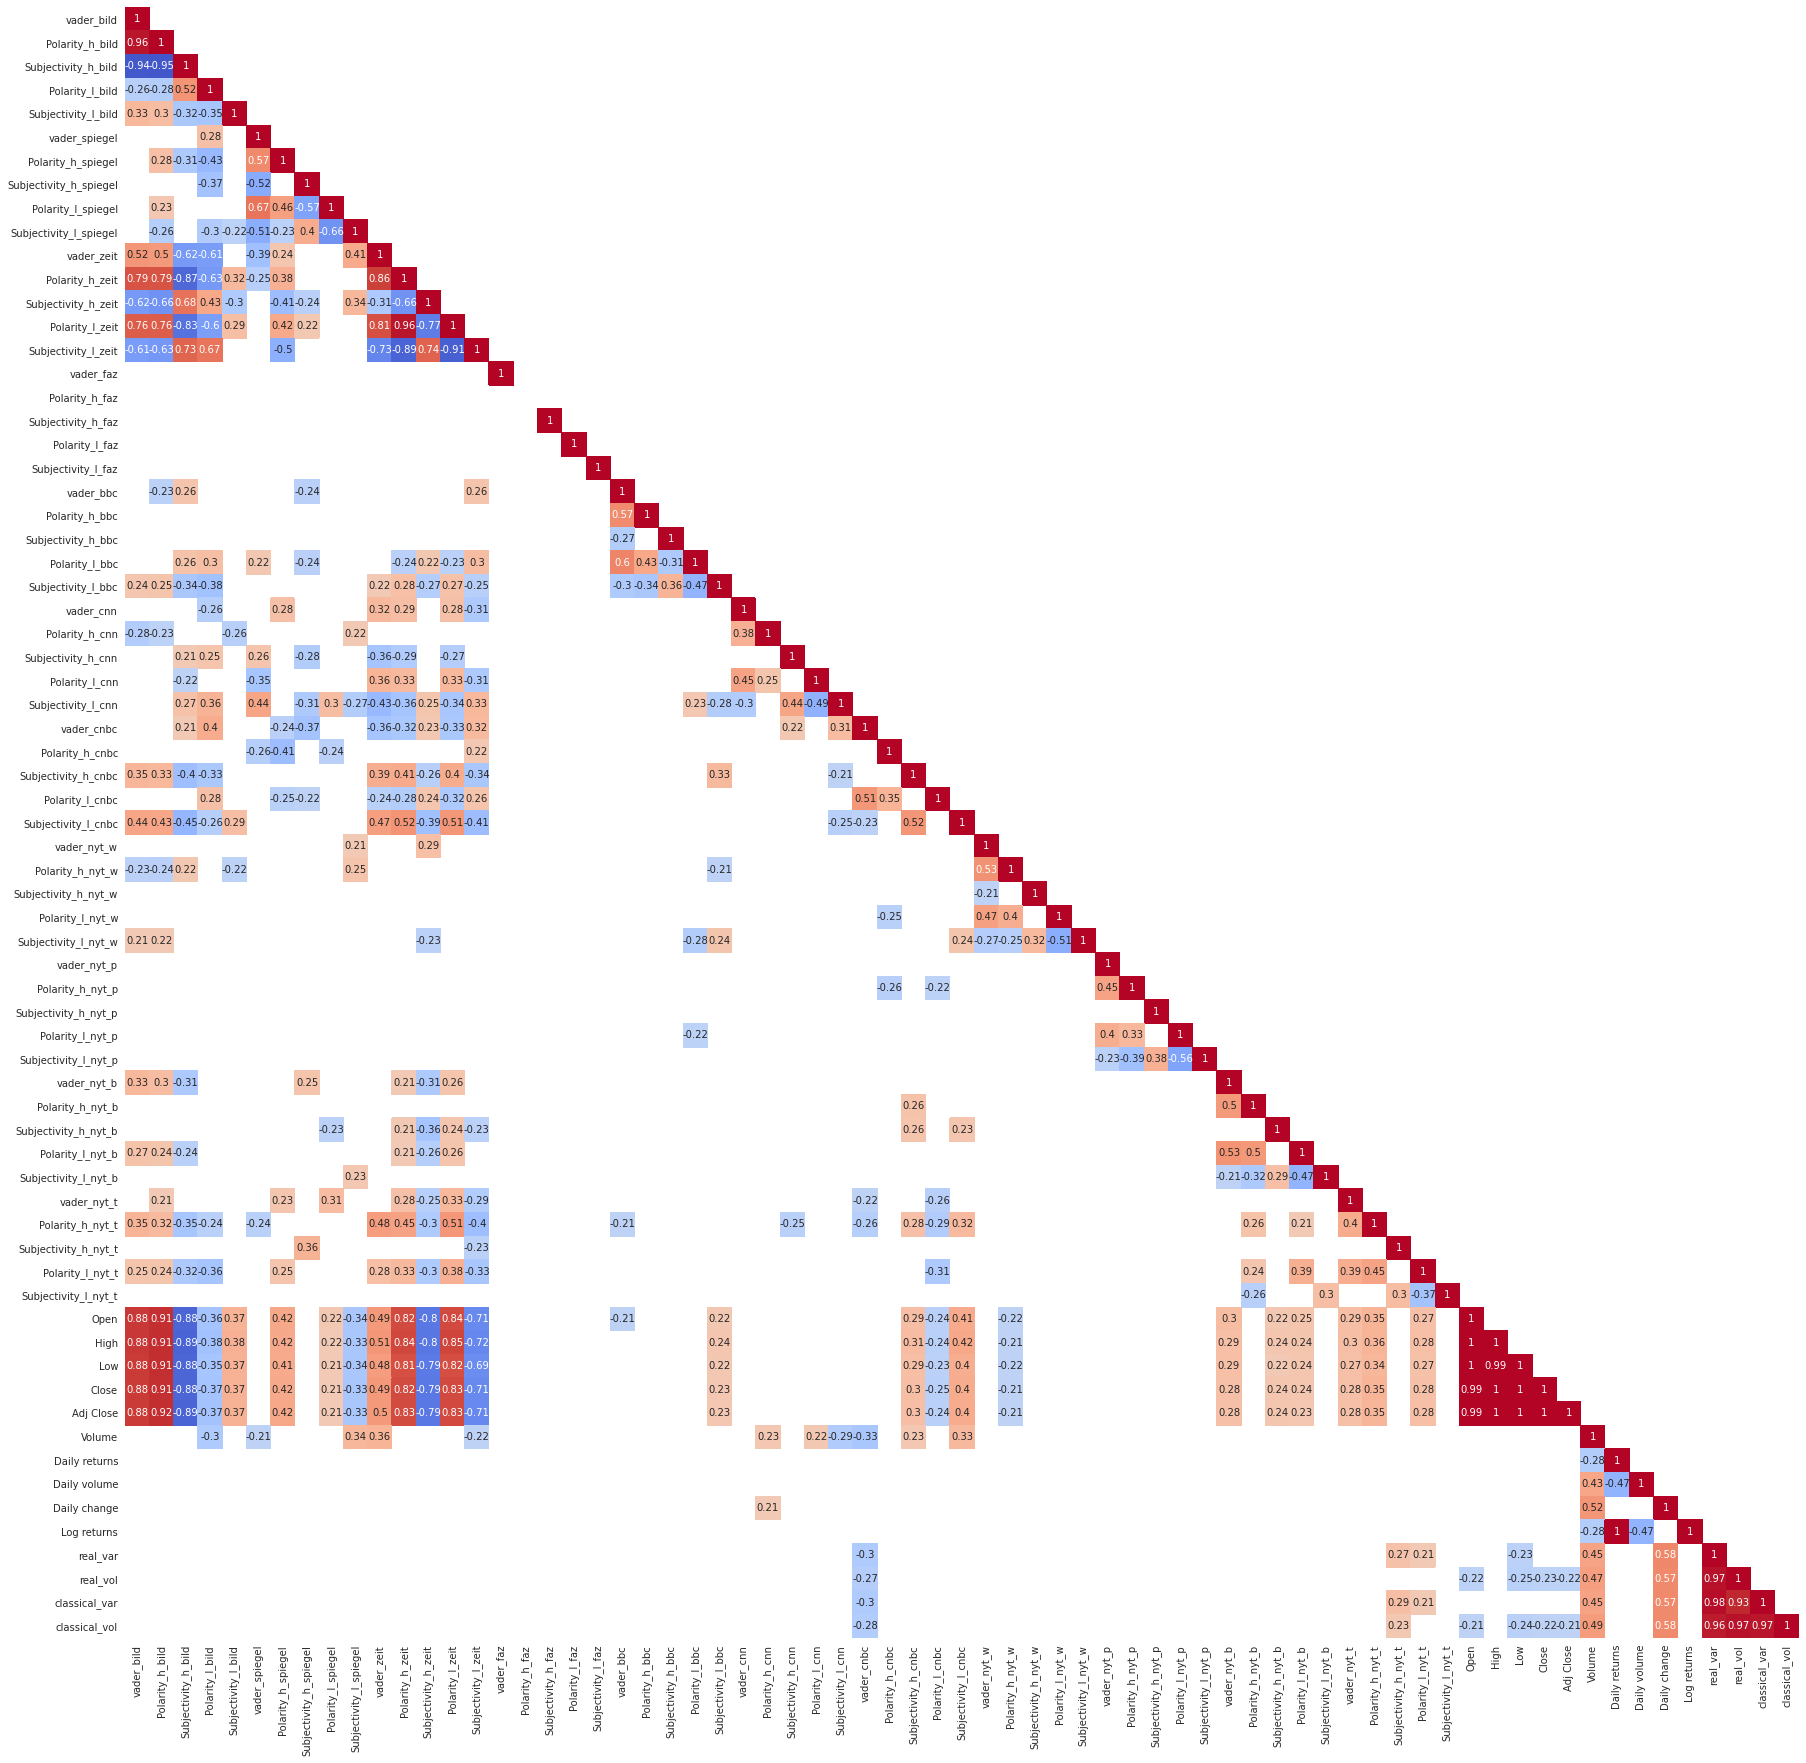

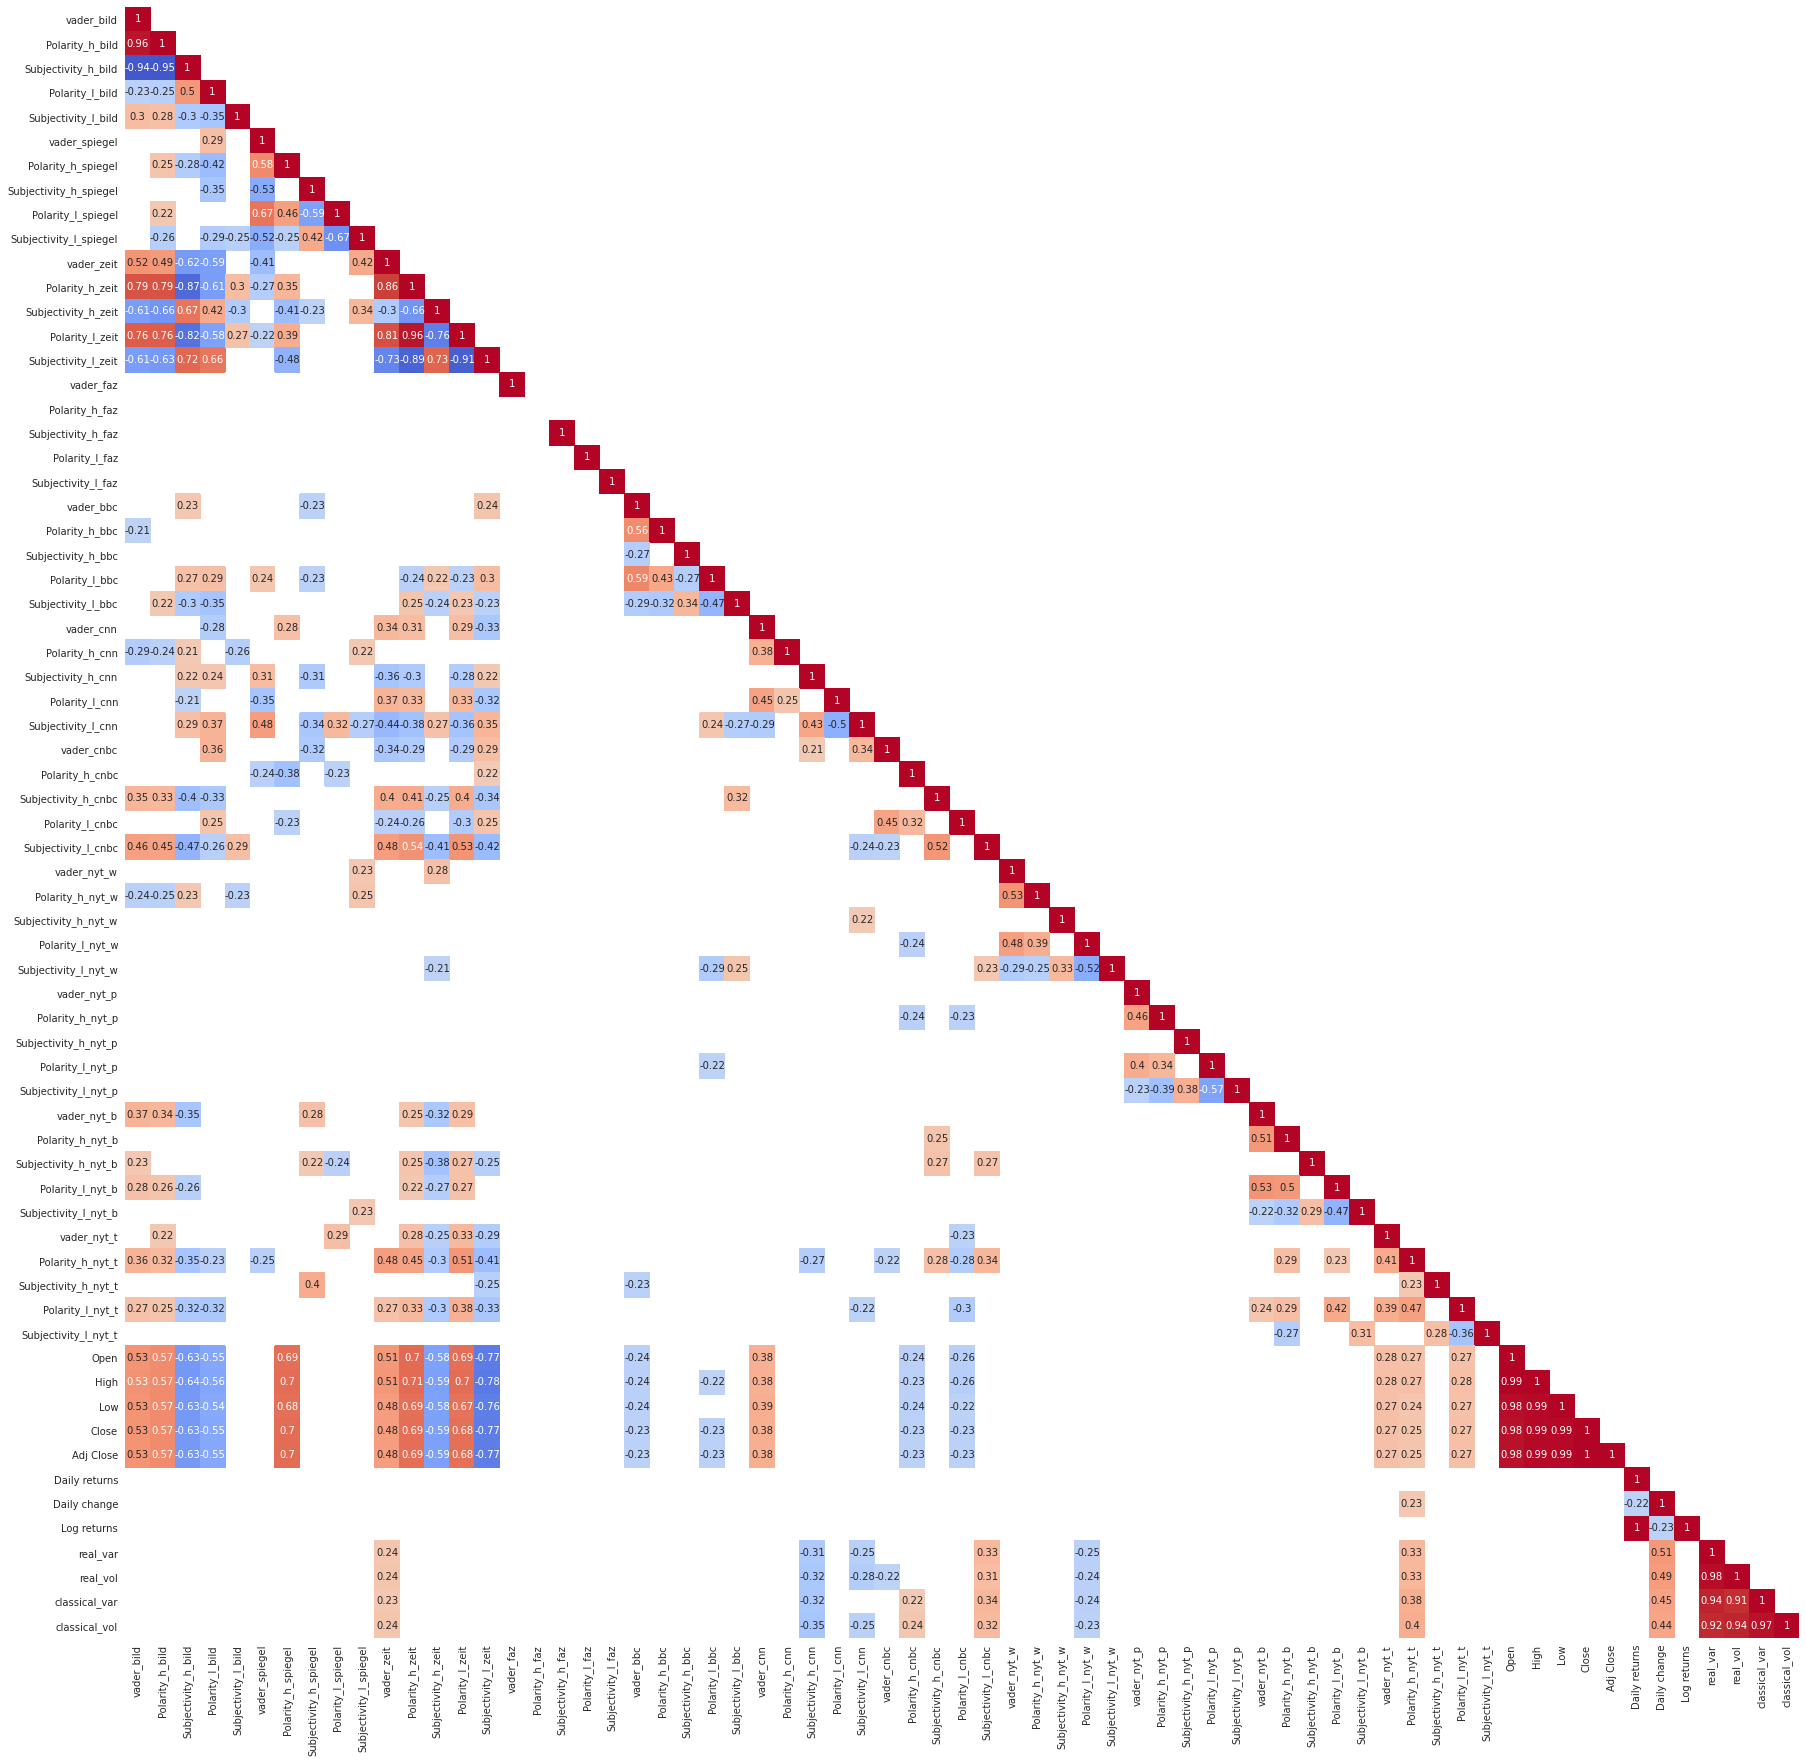

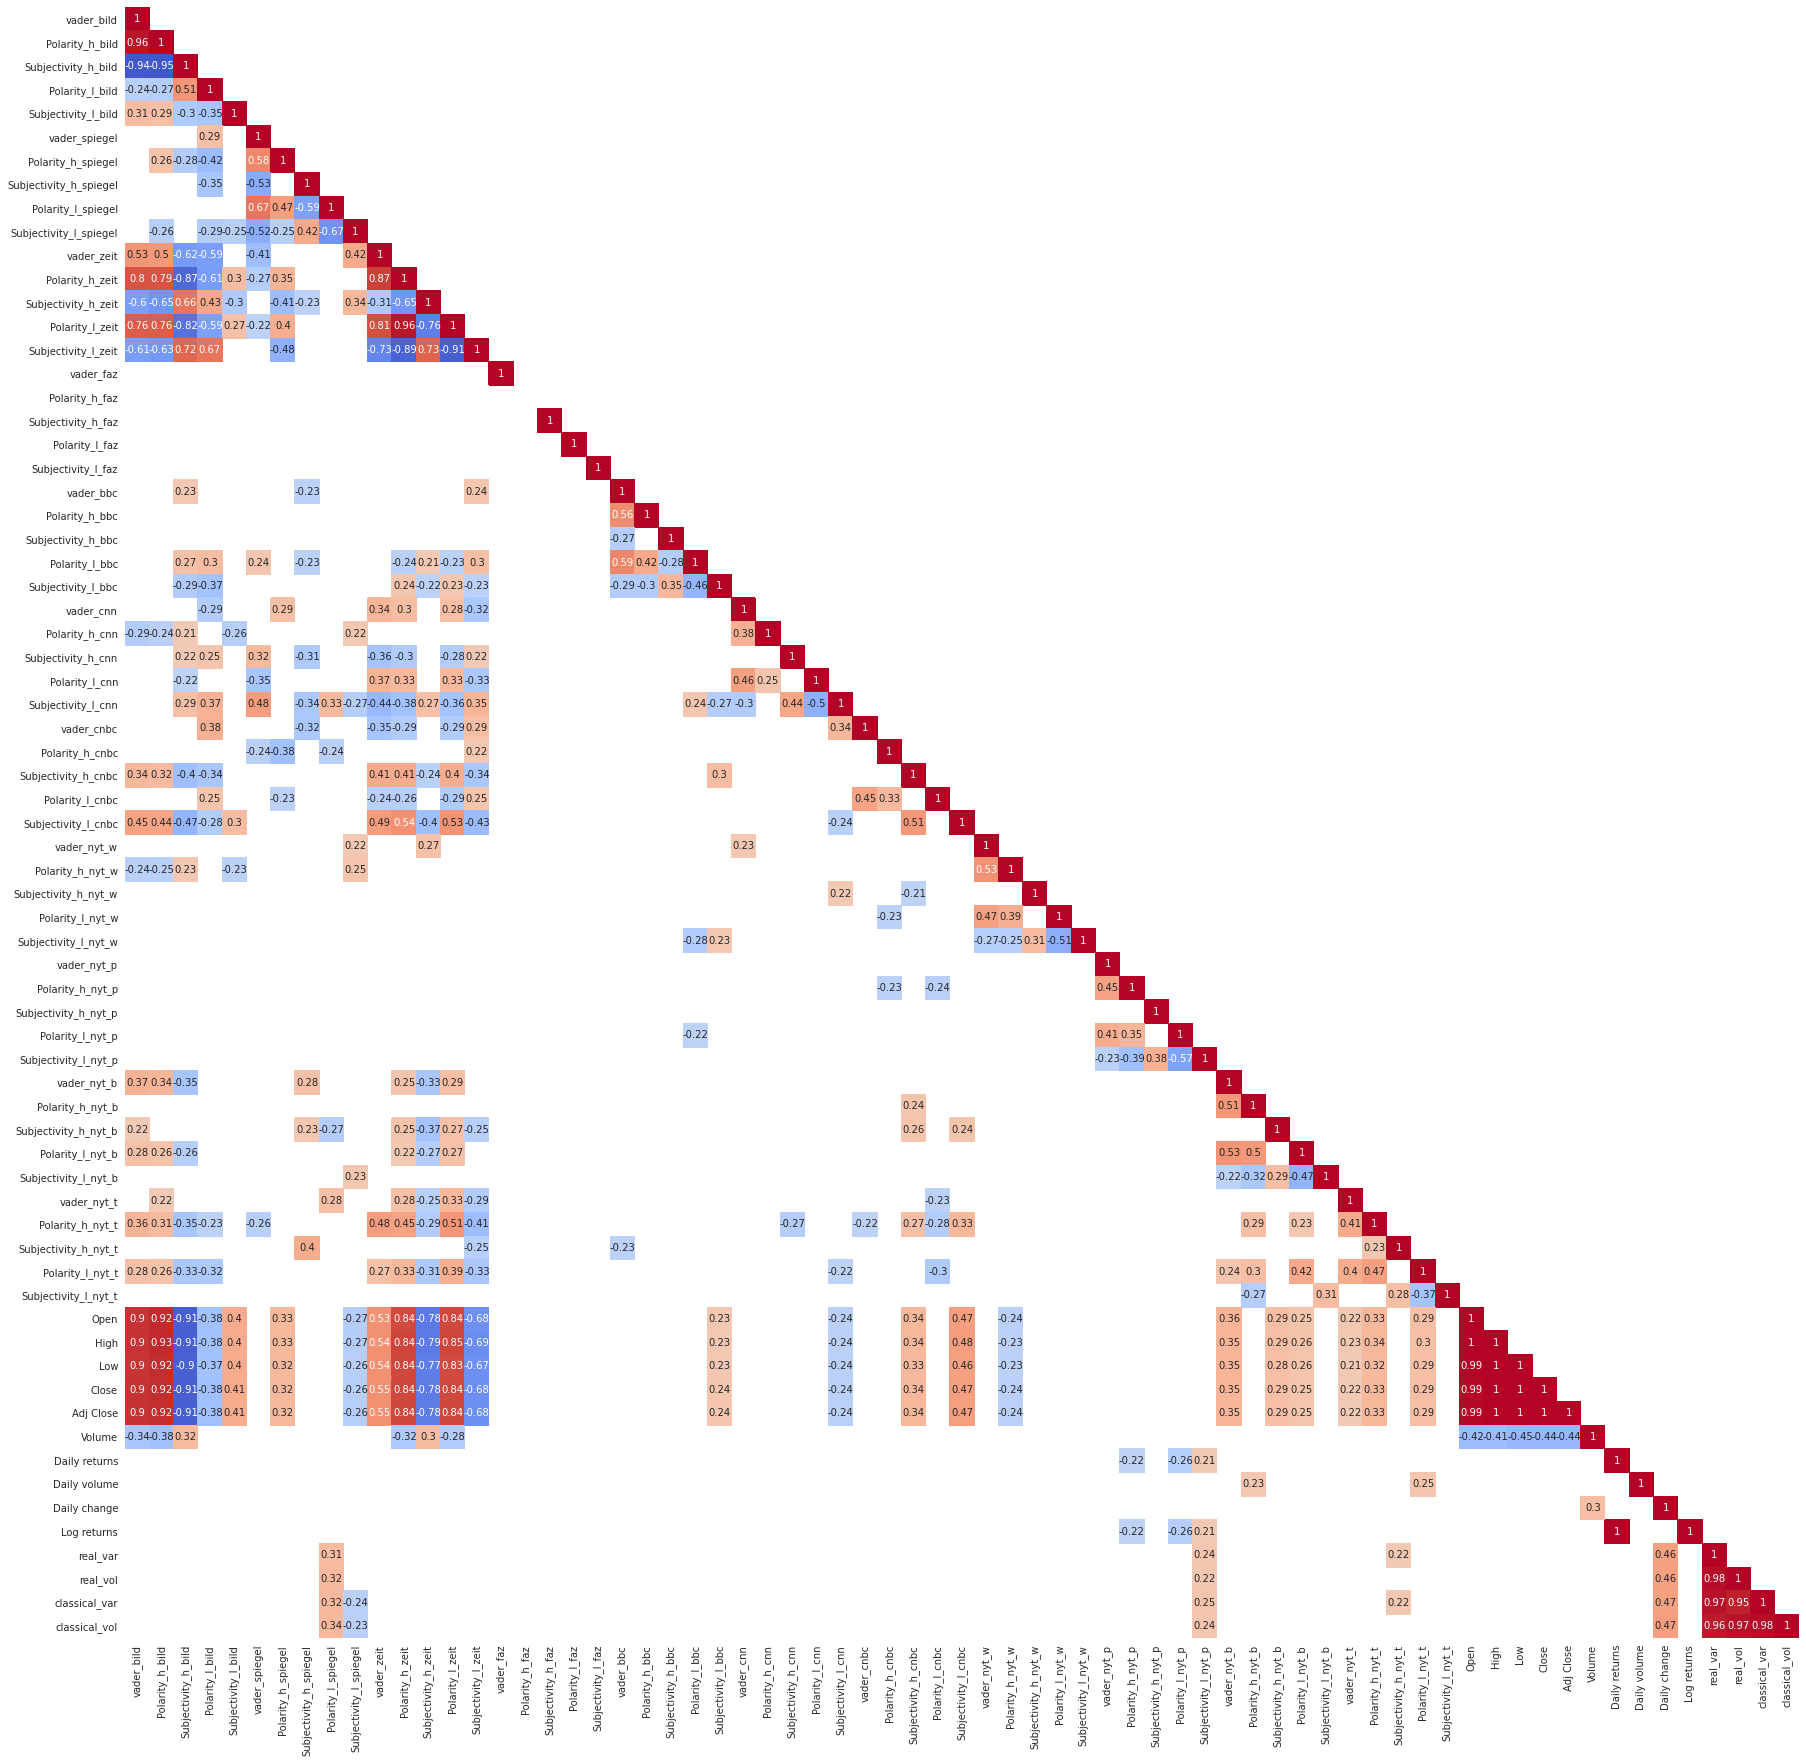

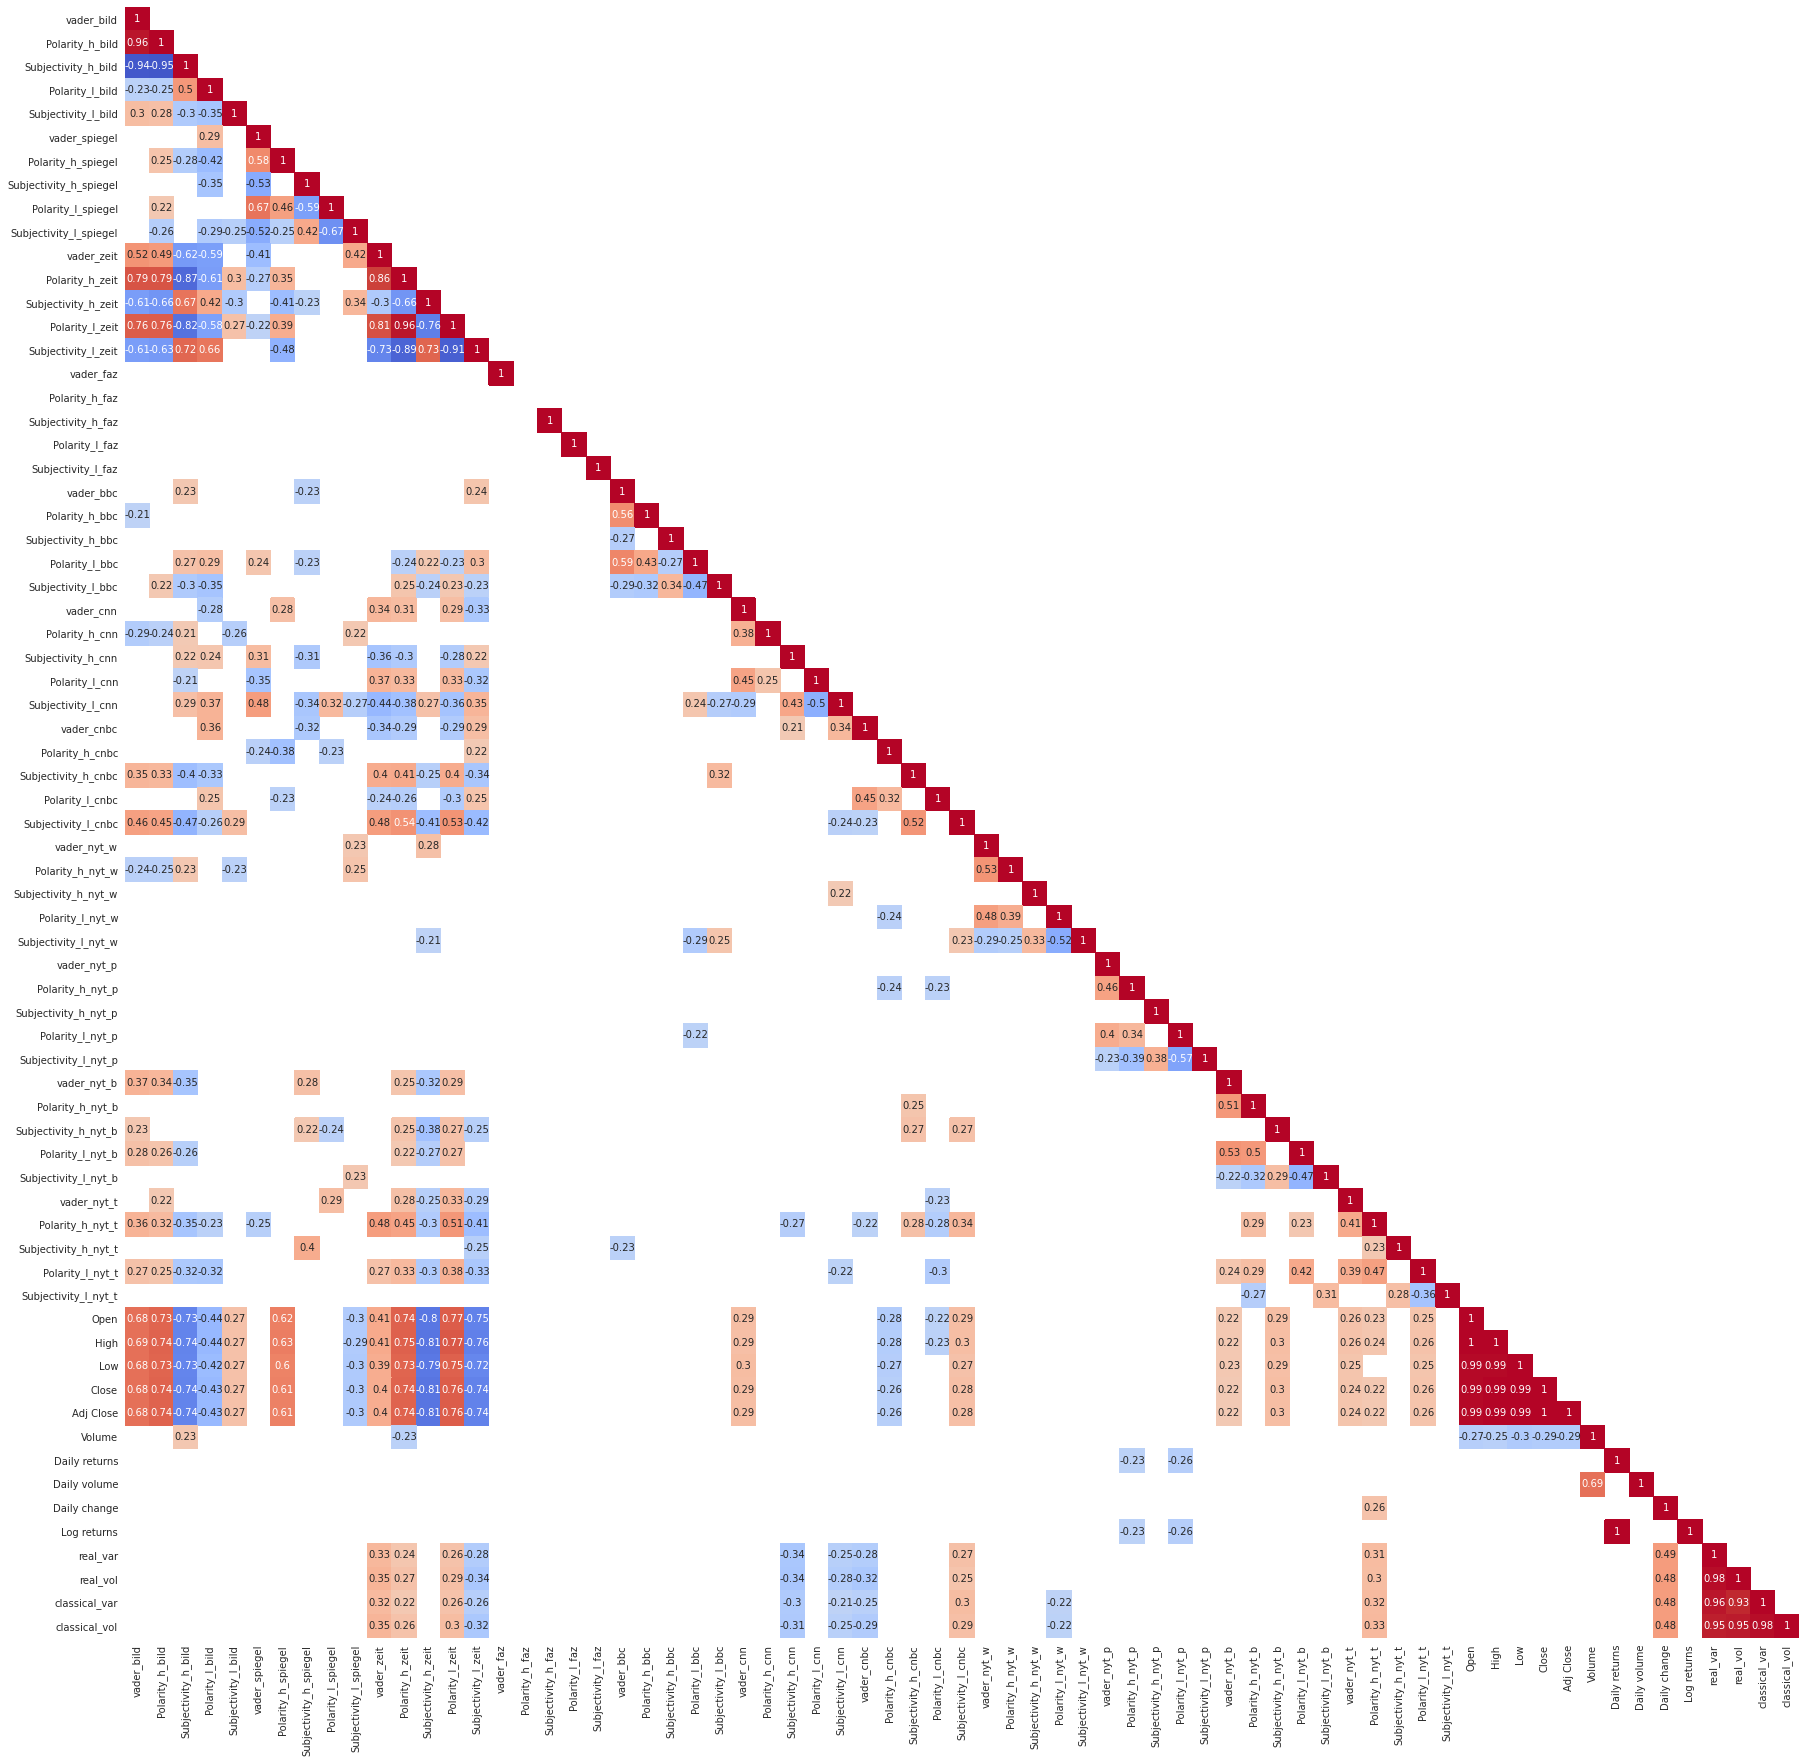

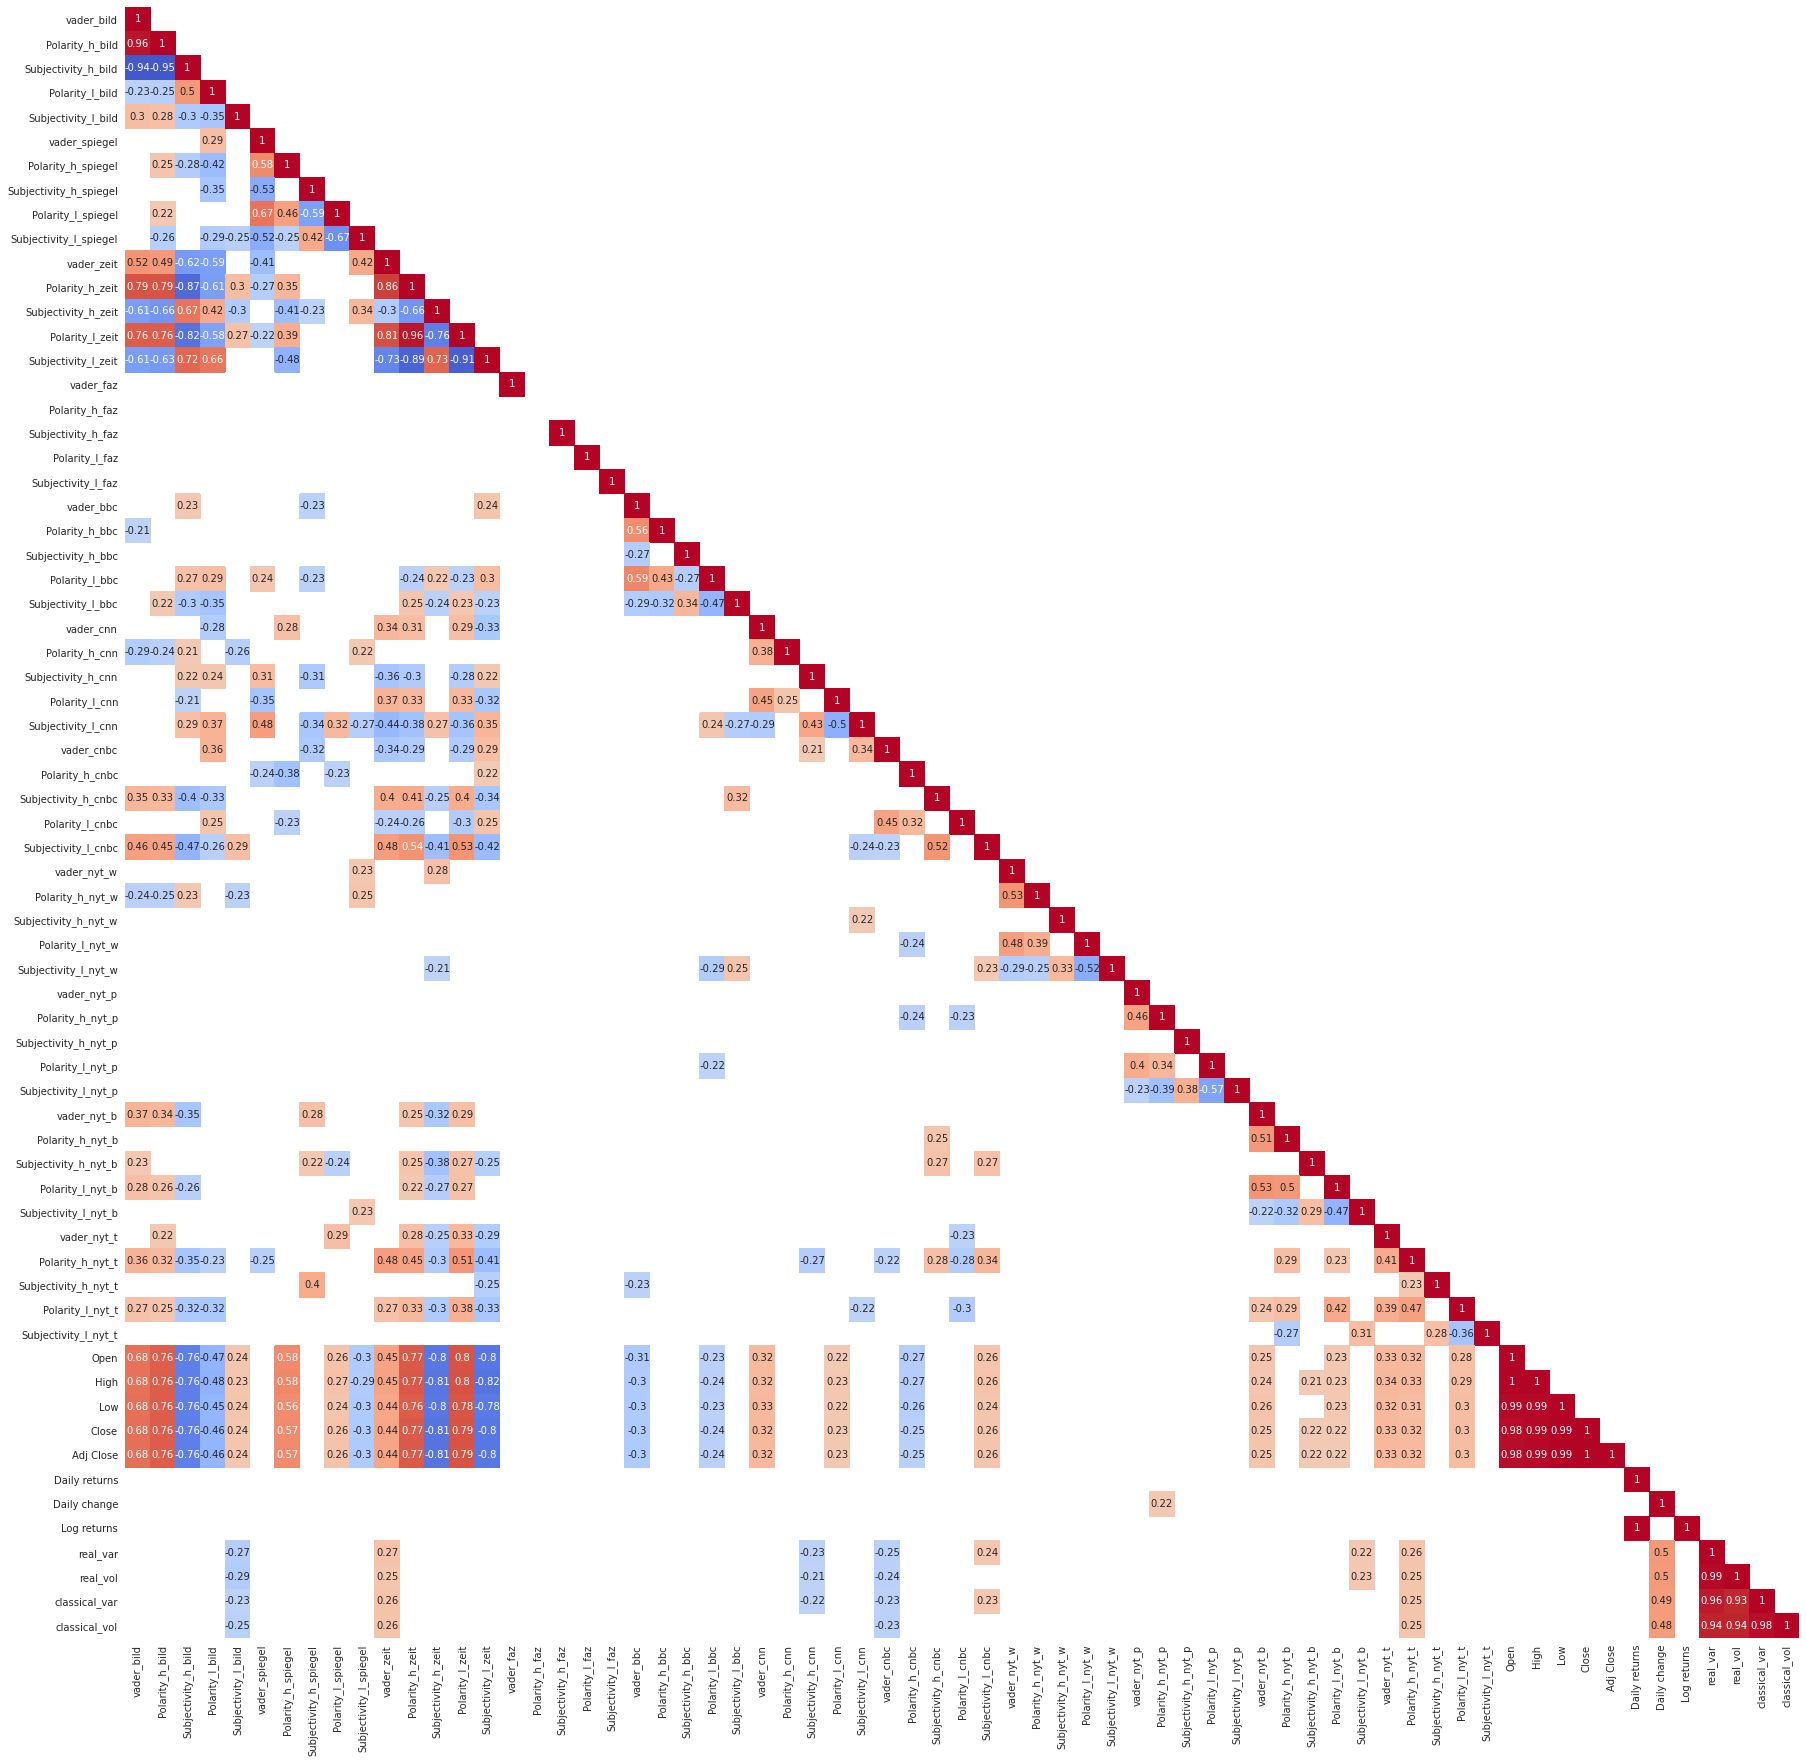

In [25]:
for m in market_data:
    exec(f'make_plot({m})') 
    exec(f'plt.savefig("{m} Correlation Matrix.pdf")') 

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; 

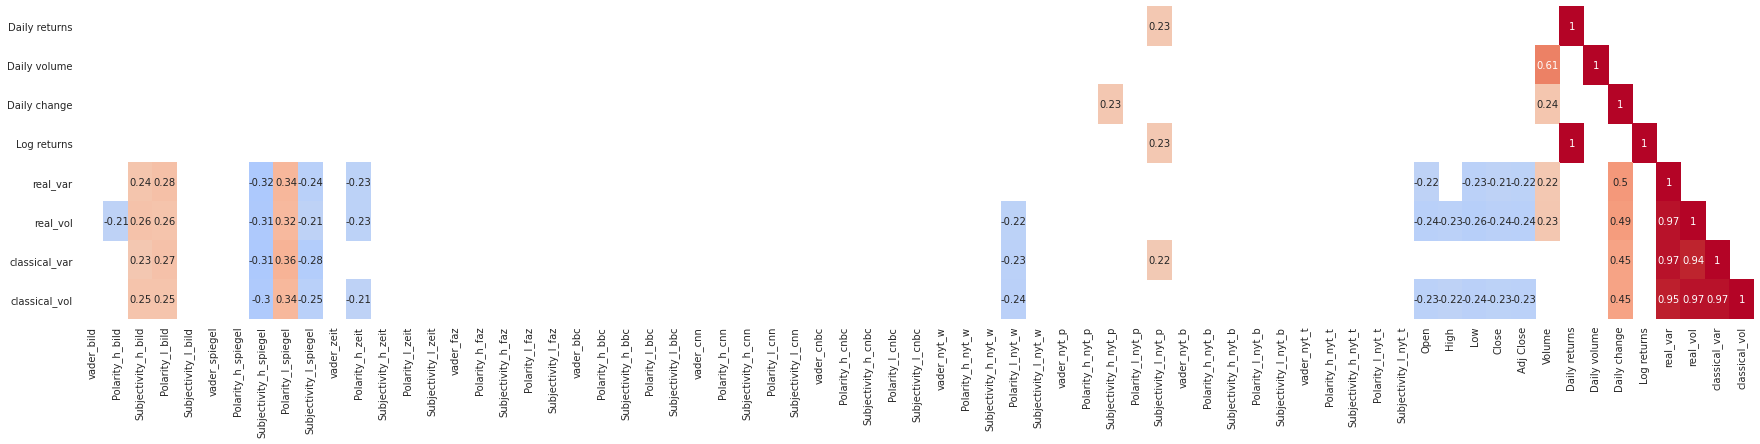

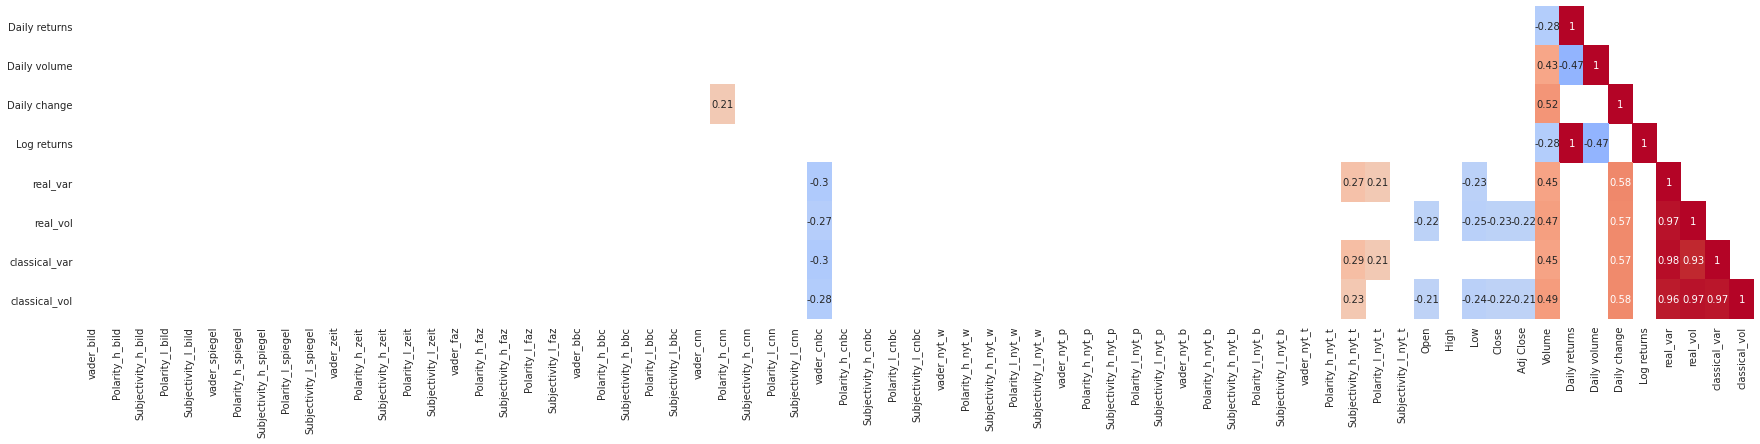

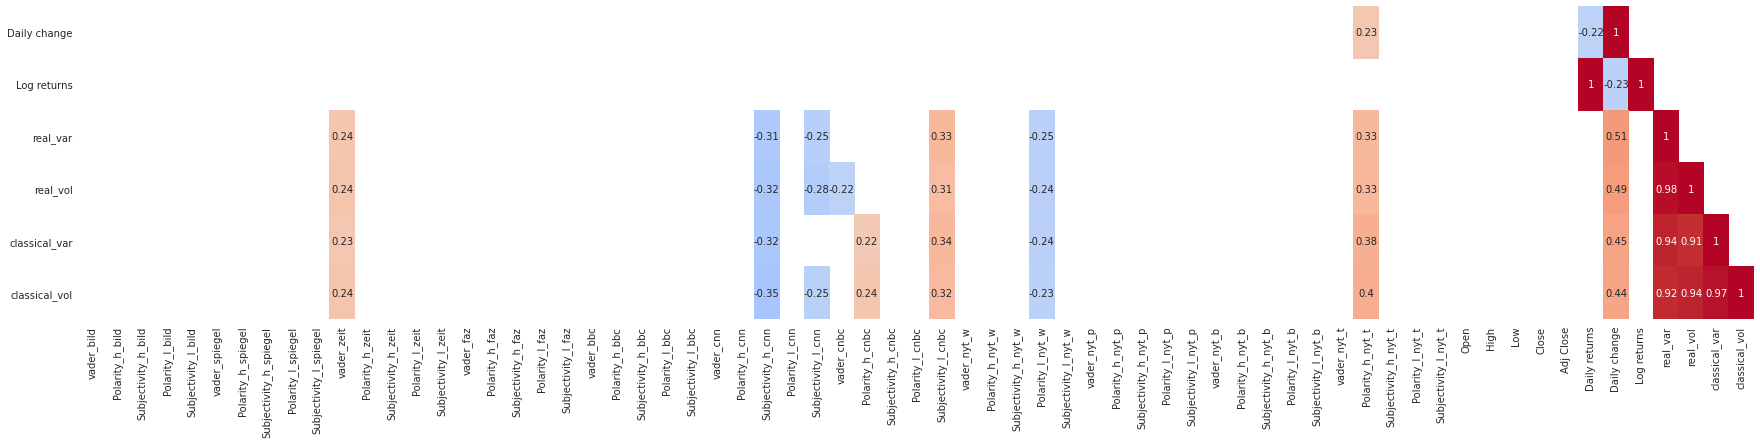

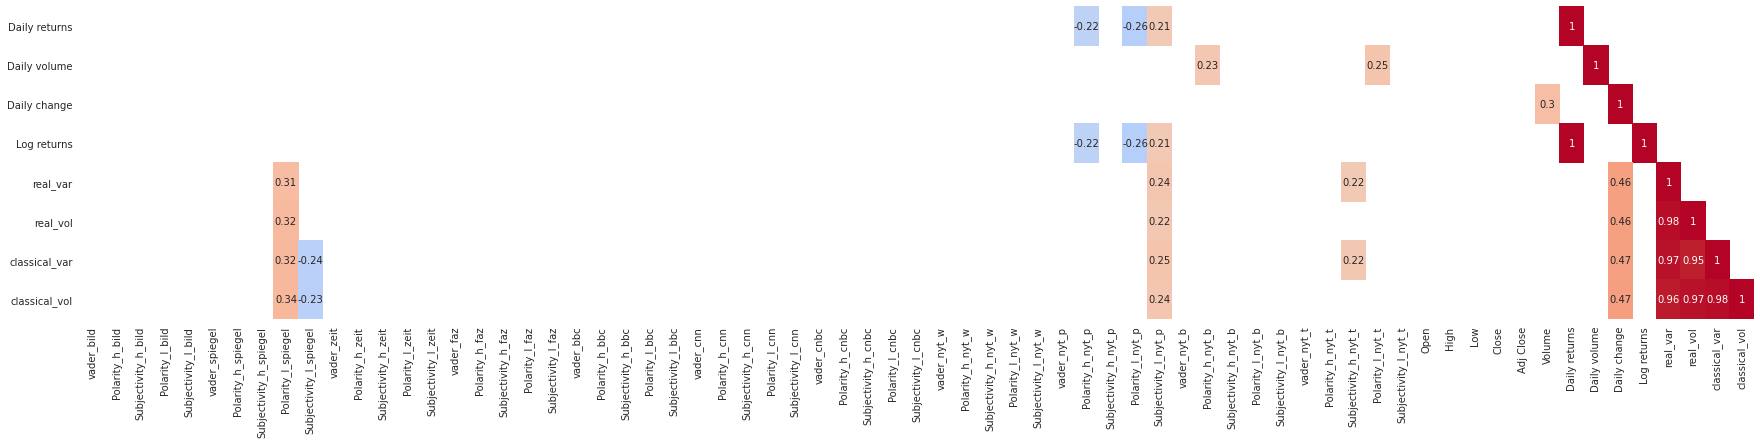

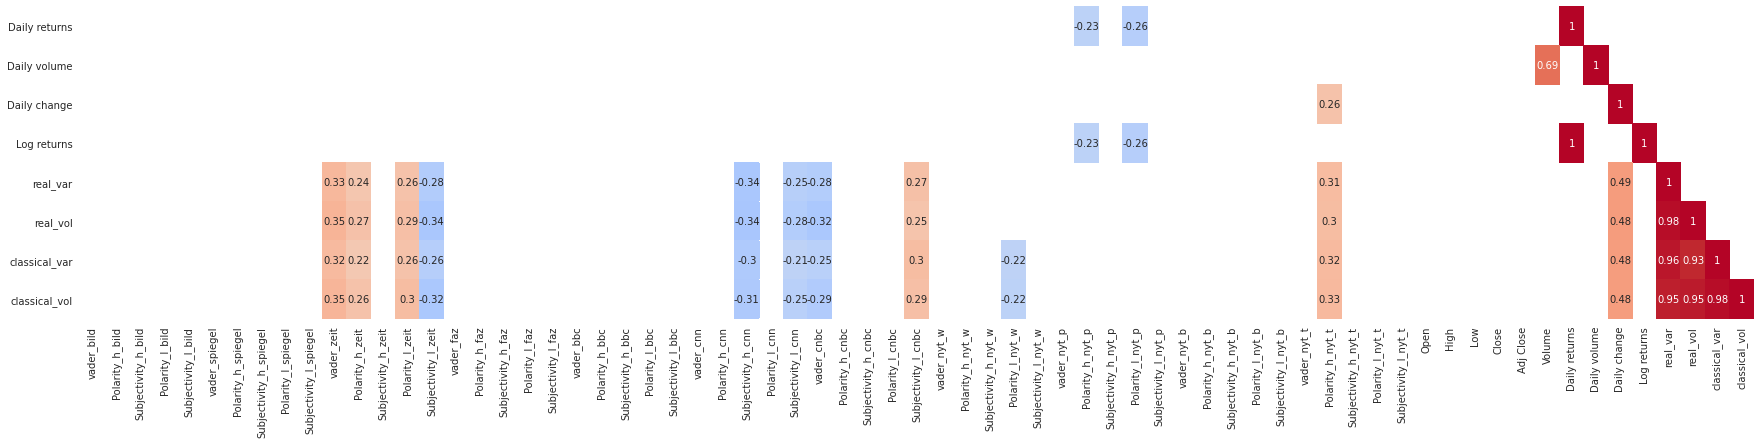

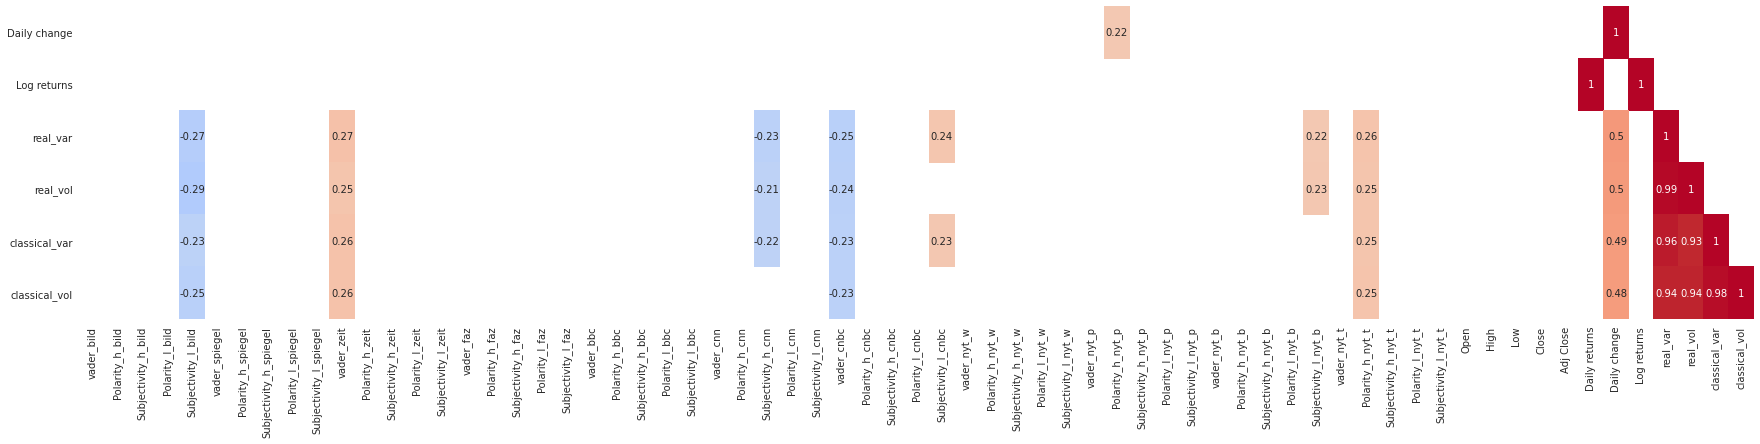

In [26]:
for m in market_data:
    exec(f'make_small_plot({m})') 
    exec(f'plt.savefig("{m} Crucial Correlation Matrix.pdf")') 

Now we can narrow it down! Lets find some Correlations we want to analyse closer:
- **MDAXI**: Vader/Subjectivity_l_ Zeit ~ Var/Vol; vader_cnbc ~ Var/Vol; Subjectivity_h_cnn ~ Var/Vol; Polarity_h_nyt_t ~ Var/Vol
- **TECDAX**: Polarity_h_nyt_t ~ Var/Vol; Subjectivity_l_cnbc ~ Var/Vol
- **SPY**: vader_cnbc ~ Var/Vol
- **DAX**: Polarity_l_spiegel ~ Var/Vol; Subjectivity_h_spiegel ~ Var/Vol

<h4>Regression Plot</h4>

<p>When it comes to simple linear regression, an excellent way to visualize the fit of our model is by using <b>regression plots</b>.</p>

<p>This plot will show a combination of a scattered data points (a <b>scatter plot</b>), as well as the fitted <b>linear regression</b> line going through the data. This will give us a reasonable estimate of the relationship between the two variables, the strength of the correlation, as well as the direction (positive or negative correlation).</p>

<h4>MDAXI: ~ Var/Vol: Vader/Subjectivity_l_ Zeit, vader_cnbc, Subjectivity_h_cnn,Polarity_h_nyt_t  </h4>
Let's calculate the Pearson Correlation Coefficient and P-values.

In [27]:
pearson_coef, p_value = stats.pearsonr(MDAXI['Subjectivity_l_zeit'], MDAXI['real_vol'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  
p_valuer = round( float(p_value), 4 )
pearson_coefr = round( float(pearson_coef), 2 )

The Pearson Correlation Coefficient is -0.34  with a P-value of P = 0.0


<h5>Comment:</h5>

<p>Since the p-value is {{ p_valuer }}, the correlation between Subjectivity_l_zeit and real_vol is statistically significant, and the linear relationship is quite strong {{ pearson_coefr }} </p>

(0.0, 0.2536588426579289)

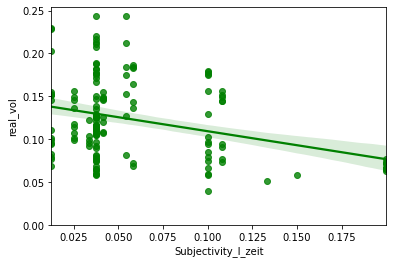

In [28]:
sns.regplot(x="Subjectivity_l_zeit", y="real_vol", data=MDAXI, color="g")
plt.ylim(0,)

In [29]:
pearson_coef, p_value = stats.pearsonr(MDAXI['vader_zeit'], MDAXI['classical_vol'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is 0.35  with a P-value of P = 0.0


(0.0, 0.12724875033425376)

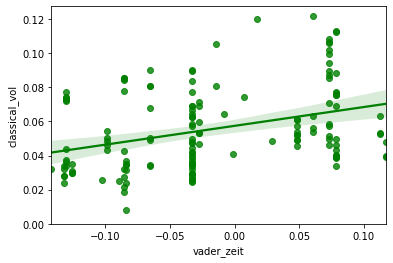

In [30]:
sns.regplot(x="vader_zeit", y="classical_vol", data=MDAXI, color="g")
plt.ylim(0,)

In [31]:
pearson_coef, p_value = stats.pearsonr(MDAXI['vader_cnbc'], MDAXI['real_vol'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is -0.32  with a P-value of P = 0.0001


(0.0, 0.2536588426579289)

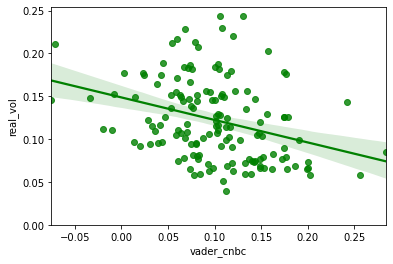

In [32]:
sns.regplot(x="vader_cnbc", y="real_vol", data=MDAXI, color="g")
plt.ylim(0,)

In [33]:
pearson_coef, p_value = stats.pearsonr(MDAXI['Subjectivity_h_cnn'], MDAXI['real_var'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is -0.34  with a P-value of P = 0.0


(0.0, 0.06215057451458848)

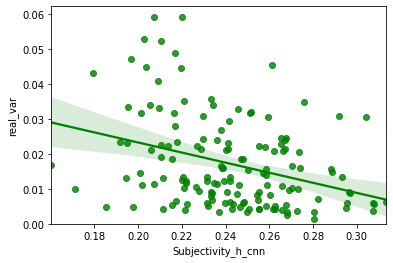

In [34]:
sns.regplot(x="Subjectivity_h_cnn", y="real_var", data=MDAXI, color="g")
plt.ylim(0,)

In [35]:
pearson_coef, p_value = stats.pearsonr(MDAXI['Polarity_h_nyt_t'], MDAXI['classical_vol'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is 0.33  with a P-value of P = 0.0001


(0.0, 0.12724875033425376)

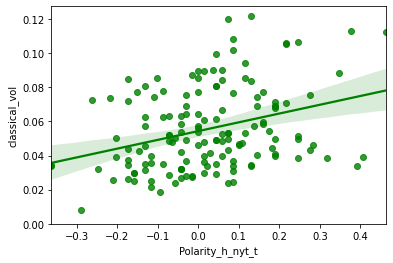

In [36]:
sns.regplot(x="Polarity_h_nyt_t", y="classical_vol", data=MDAXI, color="g")
plt.ylim(0,)

<h4>TECDAX: ~ Var/Vol: Polarity_h_nyt_t, Subjectivity_l_cnbc  </h4>
Let's calculate the Pearson Correlation Coefficient and P-values.

In [37]:
pearson_coef, p_value = stats.pearsonr(TECDAX['Polarity_h_nyt_t'], TECDAX['classical_vol'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is 0.4  with a P-value of P = 0.0


(0.0, 0.1528369609217224)

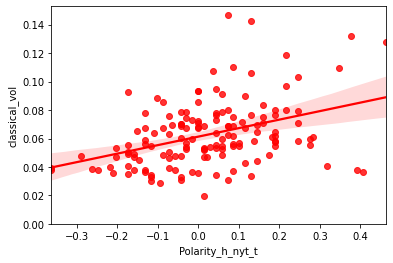

In [38]:
sns.regplot(x="Polarity_h_nyt_t", y="classical_vol", data=TECDAX, color="r")
plt.ylim(0,)

In [39]:
pearson_coef, p_value = stats.pearsonr(TECDAX['Subjectivity_l_cnbc'], TECDAX['classical_var'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is 0.34  with a P-value of P = 0.0


(0.0, 0.022543078464514595)

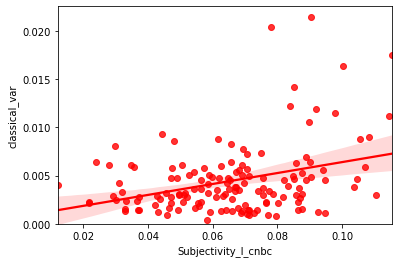

In [40]:
sns.regplot(x="Subjectivity_l_cnbc", y="classical_var", data=TECDAX, color="r")
plt.ylim(0,)

<h4>SPY: ~ Var/Vol: vader_cnbc  </h4>
Let's calculate the Pearson Correlation Coefficient and P-values.

In [41]:
pearson_coef, p_value = stats.pearsonr(SPY['vader_cnbc'], SPY['classical_var'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is -0.3  with a P-value of P = 0.0002


(0.0, 0.020752497590418584)

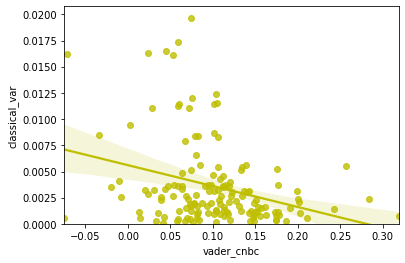

In [42]:
sns.regplot(x="vader_cnbc", y="classical_var", data=SPY, color="y")
plt.ylim(0,)

<h4>DAX: ~ Var/Vol: Polarity_l_spiegel, Subjectivity_h_spiegel  </h4>
Let's calculate the Pearson Correlation Coefficient and P-values.

In [43]:
pearson_coef, p_value = stats.pearsonr(DAX['Polarity_l_spiegel'], DAX['classical_var'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is 0.36  with a P-value of P = 0.0


(0.0, 0.020387042724036068)

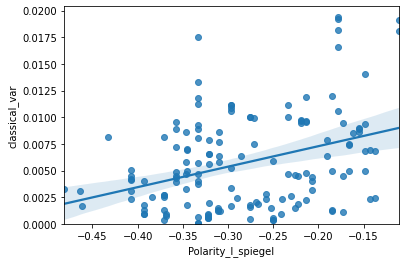

In [44]:
sns.regplot(x="Polarity_l_spiegel", y="classical_var", data=DAX)
plt.ylim(0,)

In [45]:
pearson_coef, p_value = stats.pearsonr(DAX['Subjectivity_h_spiegel'], DAX['real_var'])
print("The Pearson Correlation Coefficient is", round(pearson_coef, 2 ), " with a P-value of P =", round( float(p_value), 4 ))  

The Pearson Correlation Coefficient is -0.32  with a P-value of P = 0.0001


(0.0, 0.08509195464526507)

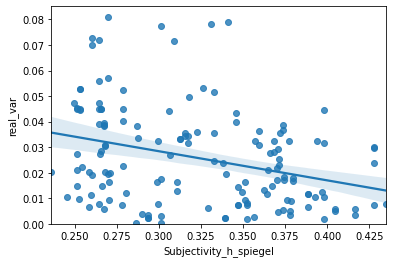

In [46]:
sns.regplot(x="Subjectivity_h_spiegel", y="real_var", data=DAX)
plt.ylim(0,)

## E. Robust analysis: Simple linear Regression <a id='8'></a>

#### Ordinary Least Squares Assumptions
OLS measures the accuracy of a linear regression model.

OLS is built on assumptions which, if held, indicate the model may be the correct lens through which to interpret our data. If the assumptions don't hold, our model's conclusions lose their validity.

Take extra effort to choose the right model to avoid Auto-esotericism/Rube-Goldberg’s Disease.

Here are the OLS assumptions:

1. Linearity: A linear relationship exists between the dependent and predictor variables. If no linear relationship exists, linear regression isn't the correct model to explain our data.
2. No multicollinearity: Predictor variables are not collinear, i.e., they aren't highly correlated. If the predictors are highly correlated, try removing one or more of them. Since additional predictors are supplying redundant information, removing them shouldn't drastically reduce the Adj. R-squared (see below).
3. Zero conditional mean: The average of the distances (or residuals) between the observations and the trend line is zero. Some will be positive, others negative, but they won't be biased toward a set of values.
4. Homoskedasticity: The certainty (or uncertainty) of our dependent variable is equal across all values of a predictor variable; that is, there is no pattern in the residuals. In statistical jargon, the variance is constant.
5. No autocorrelation (serial correlation): Autocorrelation is when a variable is correlated with itself across observations. For example, a stock price might be serially correlated if one day's stock price impacts the next day's stock price.


Simple Linear Regression
Simple linear regression uses a single predictor variable to explain a dependent variable. A simple linear regression equation is as follows:
$$
y_i=α+βx_i+ϵ_i
$$
Where:

$y$
 = dependent variable

$β$
 = regression coefficient

$α$
 = intercept (expected mean value of housing prices when our independent variable is zero)

$x$
 = predictor (or independent) variable used to predict $y$

$ϵ$
 = the error term, which accounts for the randomness that our model can't explain.

Using ```statsmodels```' ols function, we construct our model setting **Stock market returns** as a function of **news sentiment**. We assume that an increase in the **Sentiment**  will have equivalent effects on **stock returns**. Maybe we're wrong, but we have to start somewhere!

The code below shows how to set up a simple linear regression model with **sentiment** as our **predictor variable**.



#### Candidates for further analysis:
- MDAXI: Polarity_h_nyt_t ~ classical_vol
- TECDAX: Polarity_h_nyt_t ~ classical_vol
- DAX: Polarity_l_spiegel ~ classical_var

### MDAXI

In [47]:
# fit our model with .fit() and show results
# we use statsmodels' formula API to invoke the syntax below,
# where we write out the formula using ~
MDAXI_model = ols("classical_vol ~ Polarity_h_nyt_t", data=MDAXI).fit()

# summarize our model
MDAXI_model_summary = MDAXI_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
(MDAXI_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

#### To explain:

<span style='background :#aec7e8' >Adj. R-squared</span> indicates that 10% of variance can be explained by the impact of news.

<span style='background :#ffbb78' >Regression coefficient (coef)</span> represents the change in the dependent variable resulting from a one unit change in the predictor variable, all other variables being held constant. In our model, a one unit increase in *Polarity_h_nyt_t* increases *classical_vol* by 0.05.

<span style='background :#c7e9c0' >Standard error</span>  measures the accuracy of *Polarity_h_nyt_t's* coefficient by estimating the variation of the coefficient if the same test were run on a different sample. Our standard error, 0.012, is low and therefore appears accurate.

<span style='background :#bcbddc' >P-value</span> means the probability of an 0.05 increase in *classical_vol* due to a one unit increase in *Polarity_h_nyt_t* is 0%, assuming there is no relationship between the two variables. A low p-value indicates that the results are statistically significant, that is in general the p-value is less than 0.05.

<span style='background :#ff9896' >Confidence interval</span>  is a range within which our coefficient is likely to fall. We can be 95% confident that *Polarity_h_nyt_t's* coefficient will be within our confidence interval, 	 [0.027, 0.076].

#### Please see the four graphs each below.

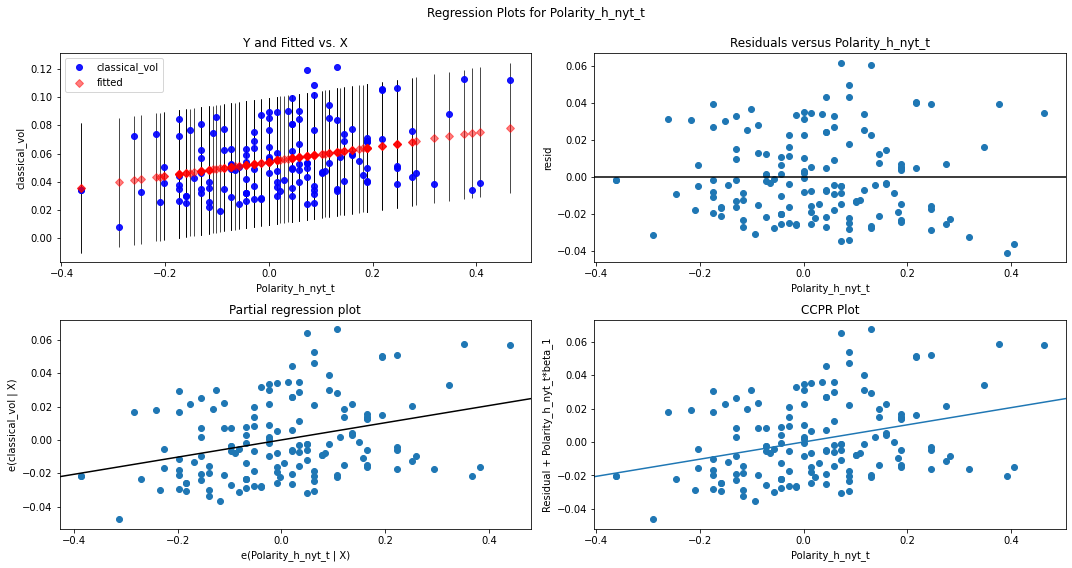

In [48]:
# This produces our four regression plots for MDAXI

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(MDAXI_model, "Polarity_h_nyt_t", fig=fig)


#### To explain:

1. The “Y and Fitted vs. X” graph plots the dependent variable against our predicted values with a confidence interval. The relationship in our graph indicates that *Polarity_h_nyt_t* and *classical_vol* are positively correlated, i.e., when one variable increases the other follows.
2. The “Residuals versus Polarity_h_nyt_t” graph shows our model's errors versus the specified predictor variable. Each dot is an observed value; the line represents the mean of those observed values. Since there's no pattern in the distance between the dots and the mean value, the OLS assumption of homoskedasticity holds.
3. The “Partial regression plot” shows the relationship between *Polarity_h_nyt_t* votes and *classical_vol*, taking in to account the impact of adding other independent variables on our existing Polarity_h_nyt_t coefficient.
4. The Component and Component Plus Residual (CCPR) plot is an extension of the partial regression plot, but shows where our trend line would lie after adding the impact of adding our other independent variables on our existing Polarity_h_nyt_t coefficient.

#### In depth Regression Plots

The next plot graphs our trend line (green), the observations (blue dots), and our confidence interval (red).

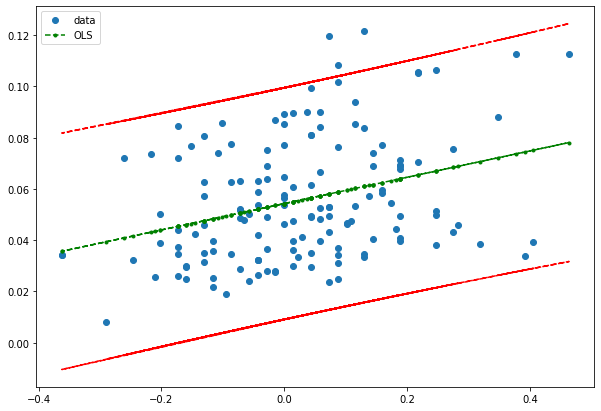

In [49]:
# predictor variable (x) and dependent variable (y)
x_MDAXI = MDAXI[['Polarity_h_nyt_t']]
y_MDAXI = MDAXI[['classical_vol']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(MDAXI_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x_MDAXI, y_MDAXI, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x_MDAXI, MDAXI_model.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x_MDAXI, confidence_interval_upper, 'r--')
ax.plot(x_MDAXI, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best');

### TECDAX

In [50]:
# fit our model with .fit() and show results
# we use statsmodels' formula API to invoke the syntax below,
# where we write out the formula using ~
TECDAX_model = ols("classical_vol ~ Polarity_h_nyt_t", data=TECDAX).fit()

# summarize our model
TECDAX_model_summary = TECDAX_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
(TECDAX_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

#### Please see the four graphs each below.

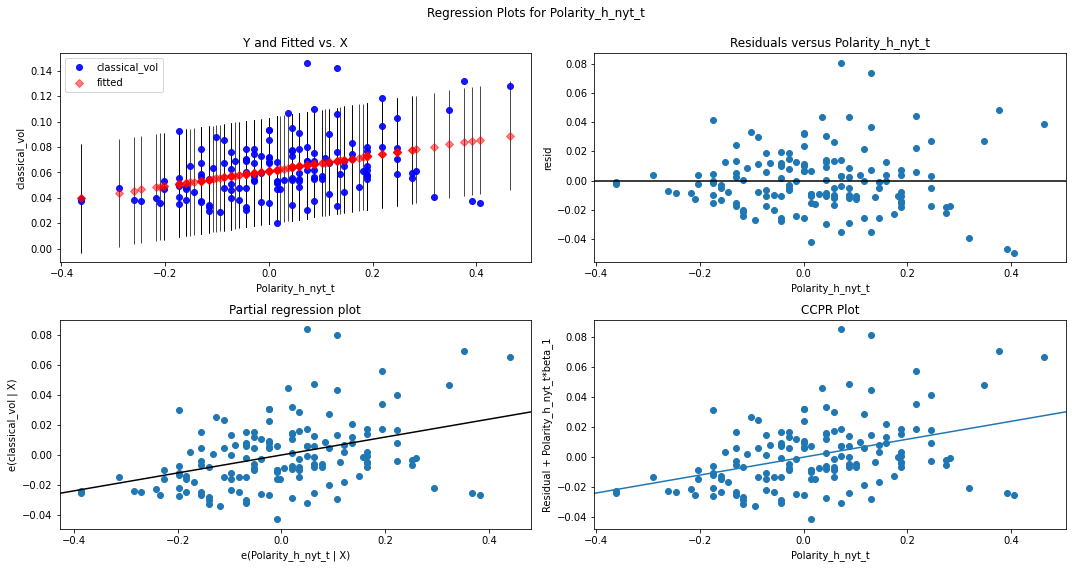

In [51]:
# This produces our four regression plots for Polarity_h_nyt_t

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(TECDAX_model, "Polarity_h_nyt_t", fig=fig)

#### In depth Regression Plots

The next plot graphs our trend line (green), the observations (blue dots), and our confidence interval (red).

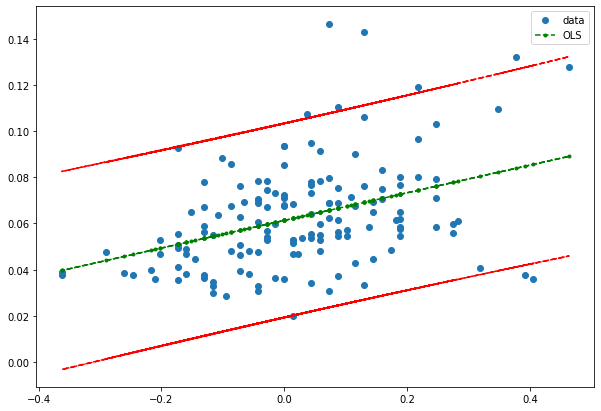

In [52]:
# predictor variable (x) and dependent variable (y)
x_TECDAX = TECDAX[['Polarity_h_nyt_t']]
y_TECDAX = TECDAX[['classical_vol']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(TECDAX_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x_TECDAX, y_TECDAX, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x_TECDAX, TECDAX_model.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x_TECDAX, confidence_interval_upper, 'r--')
ax.plot(x_TECDAX, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best');

### DAX

In [53]:
# fit our model with .fit() and show results
# we use statsmodels' formula API to invoke the syntax below,
# where we write out the formula using ~
DAX_model = ols("classical_var ~ Polarity_l_spiegel", data=DAX).fit()

# summarize our model
DAX_model_summary = DAX_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
(DAX_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

#### Please see the four graphs each below.

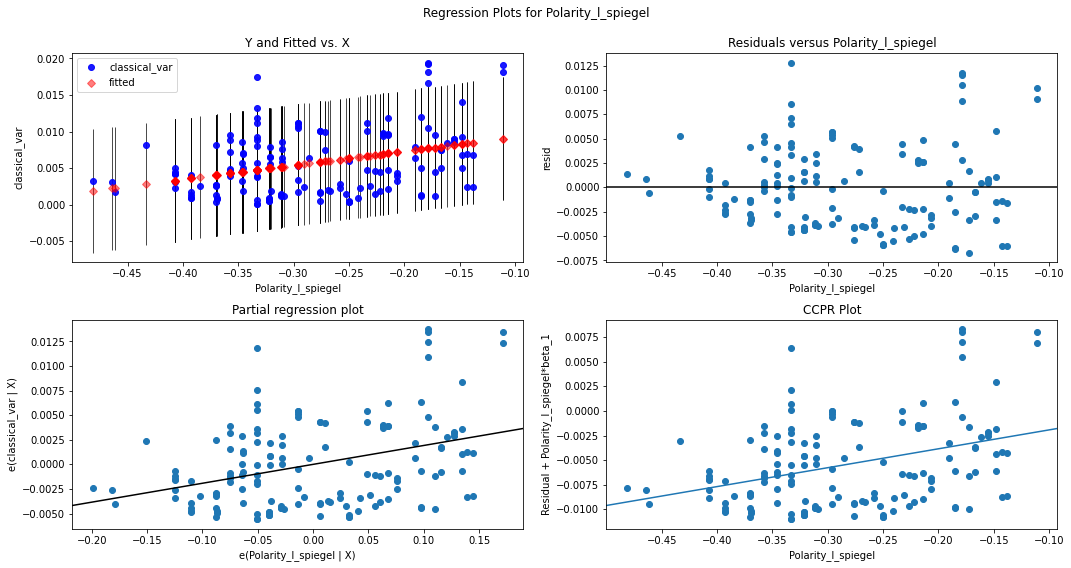

In [54]:
# This produces our four regression plots for Polarity_l_spiegel

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(DAX_model, "Polarity_l_spiegel", fig=fig)

#### In depth Regression Plots

The next plot graphs our trend line (green), the observations (blue dots), and our confidence interval (red).

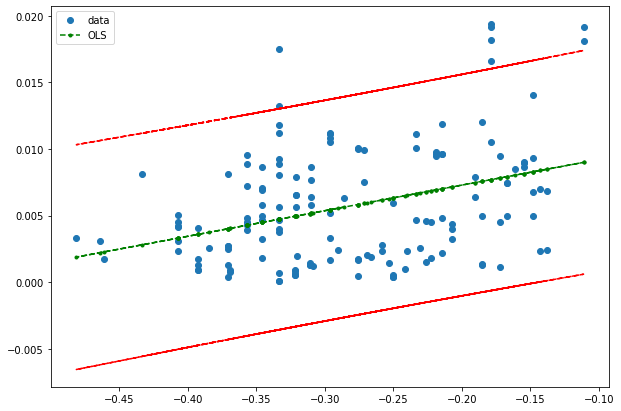

In [55]:
# predictor variable (x) and dependent variable (y)
x_DAX = DAX[['Polarity_l_spiegel']]
y_DAX = DAX[['classical_var']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(DAX_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x_DAX, y_DAX, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x_DAX, DAX_model.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x_DAX, confidence_interval_upper, 'r--')
ax.plot(x_DAX, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best');

### Evaluation

The results are quite disappointing. We can obviously find statistical correlations with stock returns, but the results are not convincing. Especially the OLS regressions can't support our initial hypothesis. The possible reasons will be discussed in the next section.

# 4. Critique <a id="9"></a>

#### Overall Result

The results are quite disappointing. We could find correlations with stock returns, but the results are not significant. This can have multiple reasons. Either there is no effect of news outlets on market activity amongst retail traders, or one of the following reasons:

**Selection of news outlets** 
- We chose the English versions of German news outlets due to the availability of our pre-trained models. But those websites are very rarely visited and updated (with News) -- this was definitely the wrong approach!
- And *if* articles were added, we still calculated the average sentiment of all headlines -- not a reliable leading indicator (maybe social media pages from news outlets are faster?). Also it should be considered to only use the sentiment of newly published headlines.
- The articles didn't always focus on finance related subjects (maybe only the financial section next time? Or parsing for buzzwords?)

**Overall Approach** 
- We started our data collection in the midst of one of the most controversial elections (and the markets didn't react as expected throughout the pandemic). 6 Months of Data might have been not enough.
- We did not parse the headlines for stocks included in the index -- this could have been an interesting feature for weights.
- We did not analyze the user interaction (number of clicks, comments, reposts,...). Social media of news outlets might be a better place to analyze the sentiment.
- Exogenous and endogenous variables: Wouldn't stock returns also influence market sentiment? Our assumption of an exogenous variable is quite weak.

**Key Takeaways** 
- The Language has to match the population of (retail) investors. 
- The Source of news (headlines) has to be the root of interaction -- Social Media probably.
- The content has to be differentiated -- can it have an impact or not.
- The Time Series needs to be robust -- If there are unique events that could sway the results, the time span needs to be larger.
- The content of the headlines needs to be included or at least parsed for Buzzwords/Stocks of corresponding indexes.
- The interaction needs to be quantified with clicks, comments, reposts etc.

# Thank you for completing this Notebook!

<hr>
<h5>
<p> <center>  <font color='gray'> Jupyter Notebook by </font> Jonas Gottal </center></p>
</h5>